# Tenencia del producto préstamo en el DataSet de Banco Checo  

Vamos a intentar extraer del datset generado que variables son las más relevantes para que una cuenta (account) tenga un péstamo (loan) y ver si de esta forma podemos generar un customer journey para conseguir que un cliente contrate un préstamo

In [1]:
import pandas as pd
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy.core.multiarray

In [3]:
#Para garantizar la replicabilidad del análisis
np.random.seed(0)

In [4]:
# Cargamos los datos que hemos procesado en R
df_original= pd.read_csv("C://Master Data Science/Master en Data Science/TFM/Transacciones de Banco Checo/DFTenenciaProductos2.csv")

In [5]:
#Comenzamos a revisar que el DF se haya importado correctamente
df_original.shape

(4500, 70)

In [6]:
df_original.head()

,Unnamed: 0,district_id,account_id,frequency,Date_Account,client_id_owner,client_id_disponent,sex_owner,birth_owner,sex_disponent,...,Num_Sym_Pension,Num_Sym_Insurance,Num_Sym_NegBal,Num_Sym_Household,Num_Sym_Statement,Num_Sym_IntDep,Num_Sym_LoanPayment,Balance_in_negative,account_disponent_bin,account_loan_bin
0,1,1,1938,Monthly,1994-06-25,2354,NaN,M,1967-12-21,NaN,...,0,0,0,50,49,54,0,0,0,0
1,2,1,1562,Monthly,1995-08-30,1894,NaN,F,1947-11-05,NaN,...,0,0,0,36,35,36,0,0,0,0
2,3,1,7099,Monthly,1996-08-20,8568,NaN,F,1971-12-03,NaN,...,0,24,0,24,23,28,7,0,0,1
3,4,1,2316,Monthly,1997-07-21,2802,NaN,F,1966-11-29,NaN,...,0,0,0,13,12,17,0,0,0,0
4,5,1,1570,Monthly,1994-03-12,1903,NaN,F,1939-08-30,NaN,...,57,0,0,53,52,53,0,0,0,0


In [7]:
# Vamos a analizar si hay missings al cargar los datos a Python
df_original.columns[df_original.isnull().sum()!=0]
#Vemos que las variables con missings provienen de variables que ya tenían esos missings en el DataFrame generado con R,
#ya que el disponent (autorizado), los préstamos y las tarjetas no son productos que tengan asociados todas las cuentas  

Index(['client_id_disponent', 'sex_disponent', 'birth_disponent', 'loan_id',
       'Date_Loan', 'Amount_Loan', 'Duration_Loan', 'Payments_Loan', 'status',
       'Status_Loan', 'owner_card_date'],
      dtype='object')

In [8]:
#Vemos como se han importado las variables del DataFrame de R al DataFrame que vamos a utilizar en Python 
print(df_original.iloc[:,0:32].dtypes)
print(df_original.iloc[:,31:61].dtypes)
print(df_original.iloc[:,60:70].dtypes)
#Observamos que las variables de factor y de fecha han modificado su tipo de variable, 
#por lo que tendremos que trabajar con ellas

Unnamed: 0                        int64
district_id                       int64
account_id                        int64
frequency                        object
Date_Account                     object
client_id_owner                   int64
client_id_disponent             float64
sex_owner                        object
birth_owner                      object
sex_disponent                    object
birth_disponent                  object
loan_id                         float64
Date_Loan                        object
Amount_Loan                     float64
Duration_Loan                   float64
Payments_Loan                   float64
status                           object
Status_Loan                      object
Ord_Insurance                     int64
Ord_Insurance_amount              int64
Ord_Household_Payment             int64
Ord_Household_Payment_amount      int64
Ord_Loan_Payment                  int64
Ord_Loan_Payment_amount         float64
Ord_Leasing                       int64


In [9]:
#Transformamos a formato fecha las variables que originalmente eran fecha en R
df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]]=df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]].apply(pd.to_datetime)
from datetime import datetime
df_original['Date_Account']=df_original['Date_Account'].apply(datetime.toordinal)
df_original['birth_owner']=df_original['birth_owner'].apply(datetime.toordinal)
df_original['birth_disponent']=df_original['birth_disponent'].apply(datetime.toordinal)
df_original['Date_Loan']=df_original['Date_Loan'].apply(datetime.toordinal)
df_original['owner_card_date']=df_original['owner_card_date'].apply(datetime.toordinal)

In [10]:
#De todas las variables de las que disponemos, vamos a seleccionar las que vamos a utilizar en este ejercicio:

#La  variable que vamos a predecir va a ser "account_loan_bin" y por tanto la denominaremos "y"

#Para este ejercicio no consideramos las variables que hemos obtenido en el mismo fichero que la variable a predecir (loan.csv):
#loan_id, Date_Loan, Amount_Loan, Duration_Loan, Payments_Loan, status, Status_Loan.

#Otras variables que no consideramos: account_id, client_id_owner, client_id_disponent, district ID y unnamed:0 porque 
#son ID's descriptivas sin información para utilizar

#La variable disponent_card_type no aporta información

#Otras variables que no consideramos:district_name, region (nombre). Utilizamos el resto de la información de variables 
#del fichero district.csv

#Haciendo referencia a district.csv , la información de crimes_95, crimes_96 y entrepreneurs la vamos a utilizar como ratio,
#ya que como veremos a continuación, de esta forma obtendremos menos impacto por un distrito con mucha población (Praga) 



In [11]:
#Las variables crimes_95, crimes_96 y entrepreneurs vamos a utilizarlas en formato ratio, tal y como calculamos en R

(array([3443.,  240.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <a list of 10 Patch objects>)

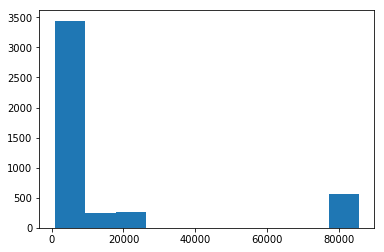

In [12]:
plt.hist(df_original['crimes_95'])

(array([ 596., 1052.,  499.,  760.,  370.,  317.,  128.,  224.,    0.,
         554.]),
 array([0.01354271, 0.01929884, 0.02505497, 0.0308111 , 0.03656723,
        0.04232336, 0.04807949, 0.05383562, 0.05959176, 0.06534789,
        0.07110402]),
 <a list of 10 Patch objects>)

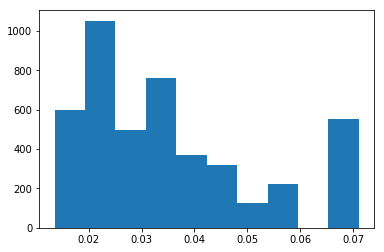

In [13]:
plt.hist(df_original['crimes_95_ratio'])

(array([3683.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  888. , 10709.9, 20531.8, 30353.7, 40175.6, 49997.5, 59819.4,
        69641.3, 79463.2, 89285.1, 99107. ]),
 <a list of 10 Patch objects>)

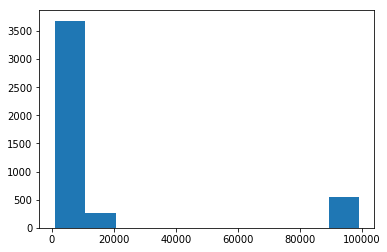

In [14]:
plt.hist(df_original['crimes_96'])

(array([1141.,  804.,  726.,  637.,  415.,   88.,  135.,    0.,    0.,
         554.]),
 array([0.0159461 , 0.02257646, 0.02920682, 0.03583717, 0.04246753,
        0.04909789, 0.05572825, 0.06235861, 0.06898896, 0.07561932,
        0.08224968]),
 <a list of 10 Patch objects>)

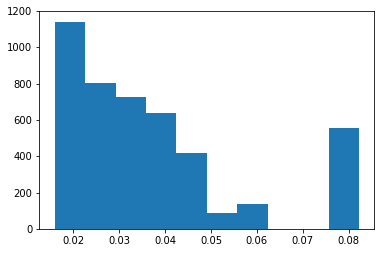

In [15]:
plt.hist(df_original['crimes_96_ratio'])

(array([200., 354., 644., 992., 517., 757., 259., 138.,  85., 554.]),
 array([ 81. ,  89.6,  98.2, 106.8, 115.4, 124. , 132.6, 141.2, 149.8,
        158.4, 167. ]),
 <a list of 10 Patch objects>)

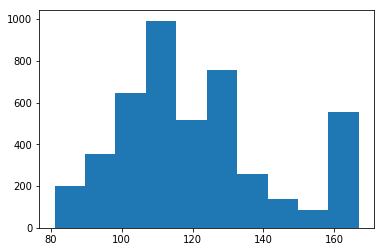

In [16]:
plt.hist(df_original['entrepreneurs'])

(array([ 969.,  322., 1256.,  793.,  312.,  388.,  177.,  192.,   43.,
          48.]),
 array([0.00013859, 0.00041431, 0.00069003, 0.00096575, 0.00124147,
        0.00151719, 0.0017929 , 0.00206862, 0.00234434, 0.00262006,
        0.00289578]),
 <a list of 10 Patch objects>)

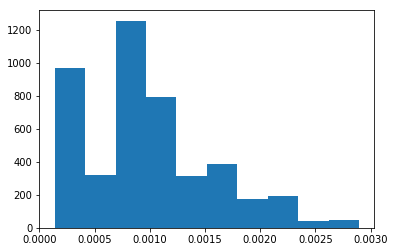

In [17]:
plt.hist(df_original['entrepreneurs_ratio'])

In [18]:
#Creamos un DataFrame con las variables que vamos a considerar numéricas
df_num=df_original[['Date_Account','birth_owner', 'birth_disponent','owner_card_date','Ord_Insurance', 'Ord_Insurance_amount',
                    'Ord_Household_Payment','Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
                    'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499', 'municip 500-1999',
                    'municip 2000-9999', 'municip > 10000', 'num_cities', 'avg_salary',  
                    'Num_Type_Credit', 'Num_Type_VYBER', 'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
                    'Num_Op_Collection','Num_Op_CashCredit', 'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard',
                    'Num_Sym_Null', 'Num_Sym_Null2','Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
                    'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep', 'Num_Sym_LoanPayment', 
                    'Balance_in_negative','Ord_Loan_Payment_amount', 'Ord_Leasing_amount','ratio_urban_inhabitants',
                    'unemployment_rate_95','unemployment_rate_96', 'crimes_95_ratio', 'crimes_96_ratio', 'entrepreneurs_ratio' ]] 

In [19]:
#Creamos un DataFrame con las variables que vamos a considerar categóricas
df_cat=df_original[['account_disponent_bin','frequency', 'sex_owner', 'owner_card_type',
       'sex_disponent']]
#Vemos que tipos tienen las variables que queremos que sean categóricas
df_cat.dtypes

account_disponent_bin     int64
frequency                object
sex_owner                object
owner_card_type           int64
sex_disponent            object
dtype: object

In [20]:
#Ponemos las variables "owner_card_type" y "account_disponent_bin" como string para poder obtener dummies
df_cat["owner_card_type"]=df_cat["owner_card_type"].astype(str)
df_cat["account_disponent_bin"]=df_cat["account_disponent_bin"].astype(str)

C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df_cat_dumm=pd.get_dummies(df_cat)

In [22]:
df_cat_dumm.dtypes
#Al pasar a dummies las variables, hemos incrementado en 8 el número total de variables

account_disponent_bin_0    uint8
account_disponent_bin_1    uint8
frequency_After_trans      uint8
frequency_Monthly          uint8
frequency_Weekly           uint8
sex_owner_F                uint8
sex_owner_M                uint8
owner_card_type_0          uint8
owner_card_type_1          uint8
owner_card_type_2          uint8
owner_card_type_3          uint8
sex_disponent_F            uint8
sex_disponent_M            uint8
dtype: object

In [23]:
df = pd.concat([df_num, df_cat_dumm], axis = 1)
df.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Loan_Payment,Ord_Leasing,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,728104,718421,1,1,0,0,1,6646,0,1,...,1,0,0,1,1,0,0,0,0,0
1,728535,711070,1,1,0,0,1,1933,0,0,...,1,0,1,0,1,0,0,0,0,0
2,728891,719864,1,1,1,528,1,236,1,0,...,1,0,1,0,1,0,0,0,0,0
3,729226,718034,1,1,0,0,1,2111,0,0,...,1,0,1,0,1,0,0,0,0,0
4,727999,708081,1,1,0,0,1,2865,0,0,...,1,0,1,0,1,0,0,0,0,0


# Vamos a generar un primer modelo benchmark

In [24]:
#Antes de probar con modelos vamos a ver si reduciendo dimensionalidad conseguimos una primera intuición

In [25]:
X = df
y = df_original["account_loan_bin"] 

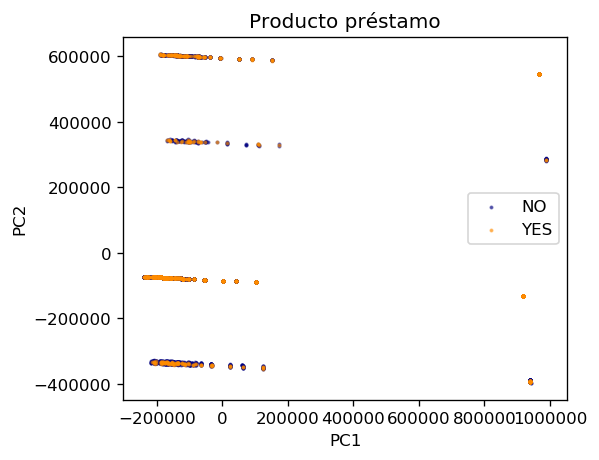

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X)
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='NO', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='YES', s=2, color='darkorange')
plt.legend()
plt.title('Producto préstamo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

In [27]:
#Del gráfico anterior no consigo sacar nada en claro
pca2 = PCA(n_components=2)
pca2.fit(X)
print(pca2.components_)
print(pca2.explained_variance_ratio_)
#De los componentes de momento tampoco sacamos ninguna conclusión. Las variables están en escalas muy distintas y por eso 
#el PCA genera resultados tan "positivos" en cuanto a explicabilidad de las 2 primeras componentes principales

[[-1.41899145e-05  3.76112969e-04  2.97418890e-02  6.65291847e-02
   1.10456611e-08  6.97541426e-05 -8.13236480e-09  4.49340526e-05
   1.92086580e-09  1.51642509e-08  1.86478704e-08  1.40767450e-04
   9.97335487e-01 -4.90984072e-05 -2.32177716e-05 -5.72845134e-06
  -5.87189940e-07 -5.04538511e-06  3.32207470e-03  2.80449536e-06
   4.49809421e-07  3.59443953e-06  1.27687280e-06  5.86459693e-07
  -1.80003778e-06  3.32766034e-06  2.90427567e-06  5.53513591e-07
   3.95002345e-06  7.30692726e-07 -9.05250243e-07  3.92910956e-07
   9.53161761e-08  5.39244984e-07  4.59238406e-07  1.27687280e-06
   3.09695048e-07  3.58832264e-07  4.66633456e-05  4.45604444e-05
   3.74408574e-05 -2.48007137e-06 -2.94393181e-06  3.92241114e-08
   4.83722236e-08 -1.07124667e-09 -4.19281050e-08  4.19281050e-08
  -4.73145522e-09 -5.56504707e-09  1.02965023e-08  3.63305616e-09
  -3.63305616e-09 -9.12049432e-08  6.41757903e-08  4.74961153e-09
   2.22795413e-08  2.15292322e-08  2.03988728e-08]
 [ 3.04437369e-06  3.7370

In [28]:
#Pasamos a hacer modelos sencillos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [29]:
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
#Probamos una Regresión logística
clf_LR=LogisticRegression(random_state=0)
clf_LR.fit(X_train,y_train)

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
def eval_modelo (clf,X_train,y_train, X_test,y_test):
    print("Datos de train:")
    print("El accuracy es",accuracy_score(y_train,clf.predict(X_train))*100,"%")
    print("La precision es",precision_score(y_train,clf.predict(X_train))*100, "%")
    print("El recall es",recall_score(y_train,clf.predict(X_train))*100,"%")
    tn, fp, fn, tp=confusion_matrix(y_train,clf.predict(X_train)).ravel()
    print("tn:",tn," fp:",fp," fn:",fn," tp:",tp)
    print("Datos de test:")
    print("El accuracy es",accuracy_score(y_test,clf.predict(X_test))*100,"%")
    print("La precision es",precision_score(y_test,clf.predict(X_test))*100, "%")
    print("El recall es",recall_score(y_test,clf.predict(X_test))*100,"%")
    tn_t, fp_t, fn_t, tp_t=confusion_matrix(y_test,clf.predict(X_test)).ravel()
    print("tn:",tn_t," fp:",fp_t," fn:",fn_t," tp:",tp_t)      

In [32]:
eval_modelo(clf_LR,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 97.25 %
La precision es 95.64315352697096 %
El recall es 85.52875695732838 %
tn: 3040  fp: 21  fn: 78  tp: 461
Datos de test:
El accuracy es 96.66666666666667 %
La precision es 94.48818897637796 %
El recall es 83.91608391608392 %
tn: 750  fp: 7  fn: 23  tp: 120


In [33]:
#Probamos con un árbol de decisión
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [34]:
eval_modelo(clf_tree,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 3061  fp: 0  fn: 0  tp: 539
Datos de test:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 757  fp: 0  fn: 0  tp: 143


In [35]:
#Los resultados de estos modelos tan sencillos están siendo extraordinarios. Vamos a investigar las razones.
#Además como las clases están desbalanceadas vamos a ir comparando el efecto de incluir oversampling o no. 
#Vamos a profundizar con Decission Trees en este primer momento ya que tiene menores requerimientos teóricos para las features 

<function matplotlib.pyplot.show(*args, **kw)>

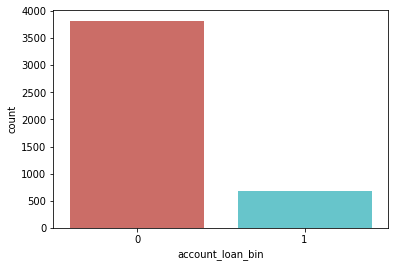

In [36]:
#Las clases a predecir (si la cuenta tiene prestamo=1 ó no tiene =0) están desbalanceadas
y2=pd.DataFrame(y)
sns.countplot(x="account_loan_bin",data=y2, palette='hls')
plt.show

In [37]:
y2['account_loan_bin'].value_counts()

0    3818
1     682
Name: account_loan_bin, dtype: int64

In [38]:
len(y2['account_loan_bin'])

4500

In [39]:
#Veamos el porcentaje que representa cada clase:
print("Las cuentas CON préstamo son el", "%.2f" % (y2['account_loan_bin'].value_counts()[0]/len(y2['account_loan_bin'])*100) ,"%")
print("Las cuentas SIN préstamo son el", "%.2f" % (y2['account_loan_bin'].value_counts()[1]/len(y2['account_loan_bin'])*100) ,"%")

Las cuentas CON préstamo son el 84.84 %
Las cuentas SIN préstamo son el 15.16 %


In [40]:
#Al estar las clases desbalanceadas hay que ir con cuidado porque un modelo que prediga siempre NO tendría un accuracy
#de casi el 85%

In [41]:
#Vamos a querer dibujar Decision Trees
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [42]:
#Función para dibujar un árbol
def dibu_arb(tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(Image(graph.create_png()))
    

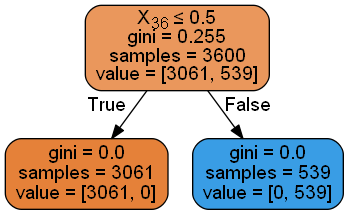

In [43]:
dibu_arb(clf_tree)

In [44]:
X_train.columns[36]
#Parece que la variable "Num_Sym_LoanPayment" contiene toda la información "account_loan_bin", 
#aunque se han extraido de ficheros distintos

'Num_Sym_LoanPayment'

In [45]:
X.columns[clf_tree.feature_importances_>0.10] #Vamos a ver las variables más importantes para el modelo

Index(['Num_Sym_LoanPayment'], dtype='object')

In [46]:
# conda install -c glemaitre imbalanced-learn

In [47]:
from imblearn.over_sampling import SMOTENC

In [48]:
#Para ver las columnas que vamos a denominar como categóricas cuando apliquemos SMOTE
print(X_train.columns)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
       'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Num_Sym_LoanPayment', 'Balance_in_negative', 'Ord_Loan_Payment_amount',
       'Ord_Leasing_amount', 'ratio_urban_inhabitants', 'unemployment_rate_95',
       'unemployment_rate_96', 'crimes_95_ratio', 'crimes_

In [49]:
smo=SMOTENC(categorical_features=range(46,59),random_state=0)#Las variables categóricas van a ser de la 46 a la 59
os_X,os_y=smo.fit_sample(X_train, y_train)
columns = X_train.columns
os_X = pd.DataFrame(data=os_X,columns=columns)
os_y= pd.DataFrame(data=os_y,columns=['account_loan_bin'])

In [50]:
#Chequeamos que SMOTENC funciona como esperábamos

print("length of oversampled data is ",len(os_X))
print("Number of loans=0 in oversampled data",len(os_y[os_y['account_loan_bin']==0]))
print("Number of loans=1",len(os_y[os_y['account_loan_bin']==1]))
print("Proportion of loans=0 is ",len(os_y[os_y['account_loan_bin']==0])/len(os_X))
print("Proportion of loans=1 is ",len(os_y[os_y['account_loan_bin']==1])/len(os_X))

os_bin=os_X[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
print("unique de variables categóricas",unique(os_bin))
print("unique de variable y",unique(os_y))

length of oversampled data is  6122
Number of loans=0 in oversampled data 3061
Number of loans=1 3061
Proportion of loans=0 is  0.5
Proportion of loans=1 is  0.5
unique de variables categóricas [0. 1.]
unique de variable y [0 1]


In [51]:
os_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_tree_os=os_clf_tree.fit(os_X,os_y)

In [52]:
eval_modelo(clf_tree_os,os_X,os_y, X_test, y_test)
#Obtenemos los mismos resultados con y sin SMOTE. Lógicamente porque estamos suponiendo que la variable 
#'Num_Sym_LoanPayment' contiene la información de si la cuenta tiene un préstamo o no

Datos de train:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 3061  fp: 0  fn: 0  tp: 3061
Datos de test:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 757  fp: 0  fn: 0  tp: 143


In [53]:
#Vemos que tener un préstamo correlaciona de forma muy significativa con las variables:Ord_Loan_Payment,Num_Sym_LoanPayment y 
#Ord_Loan_Payment_amount
df_original.corr()["account_loan_bin"]

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [54]:
#Vemos las correlaciones de las variables anteriores
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Loan_Payment"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Loan_Payment_amount"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Sym_LoanPayment"]))

[[1.         0.97080682]
 [0.97080682 1.        ]]
[[1.         0.83143262]
 [0.83143262 1.        ]]
[[1.        0.8227983]
 [0.8227983 1.       ]]


In [55]:
#Vamos a ver qué resultados obtenemos eliminando la variable 'Num_Sym_LoanPayment'
X1=X.drop(['Num_Sym_LoanPayment'], axis=1)

In [56]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=0)

In [57]:
X1_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_treeX1=X1_clf_tree.fit(X1_train,y1_train)

In [58]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(45,58),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X1,os_y1=smo.fit_sample(X1_train, y1_train)
columns = X1_train.columns
os_X1 = pd.DataFrame(data=os_X1,columns=columns)
os_y1= pd.DataFrame(data=os_y1,columns=['account_loan_bin'])

In [59]:
#Chequeamos que SMOTENC funciona como esperábamos

print("length of oversampled data is ",len(os_X1))
print("Number of loans=0 in oversampled data",len(os_y1[os_y1['account_loan_bin']==0]))
print("Number of loans=1",len(os_y1[os_y1['account_loan_bin']==1]))
print("Proportion of loans=0 is ",len(os_y1[os_y1['account_loan_bin']==0])/len(os_X1))
print("Proportion of loans=1 is ",len(os_y1[os_y1['account_loan_bin']==1])/len(os_X1))

os_bin=os_X1[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
print("unique de variables categóricas",unique(os_bin))
print("unique de variable y",unique(os_y1))

length of oversampled data is  6122
Number of loans=0 in oversampled data 3061
Number of loans=1 3061
Proportion of loans=0 is  0.5
Proportion of loans=1 is  0.5
unique de variables categóricas [0. 1.]
unique de variable y [0 1]


In [60]:
#Vemos que el oversampling funciona bien, no lo vamos a chequear las próximas ocasiones

In [61]:
osX1_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_tree_osX1=osX1_clf_tree.fit(os_X1,os_y1)

In [62]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX1,X1_train,y1_train, X1_test, y1_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX1,os_X1,os_y1, X1_test, y1_test)

Sin Oversampling
Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140
Con Oversampling
Datos de train:
El accuracy es 99.73864750081673 %
La precision es 99.64134333224649 %
El recall es 99.83665468801046 %
tn: 3050  fp: 11  fn: 5  tp: 3056
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


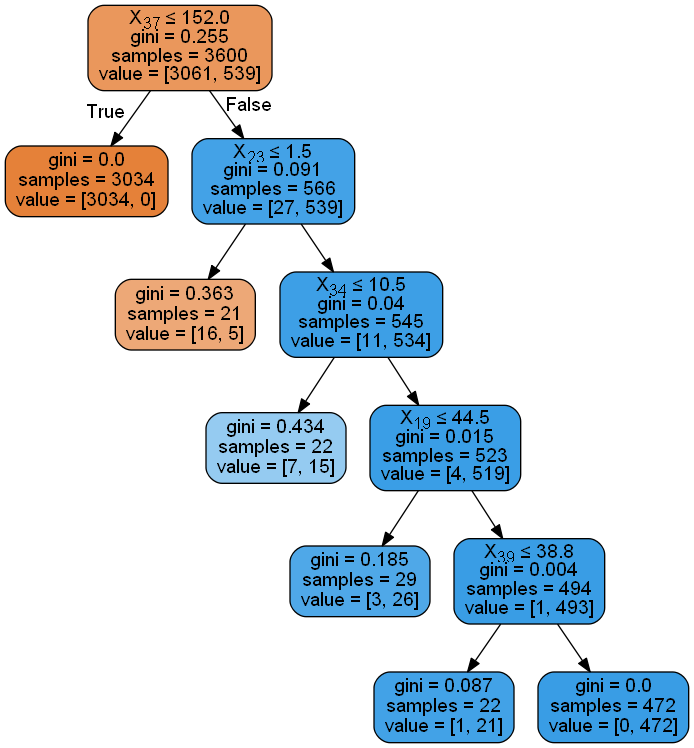

In [63]:
dibu_arb(clf_treeX1)

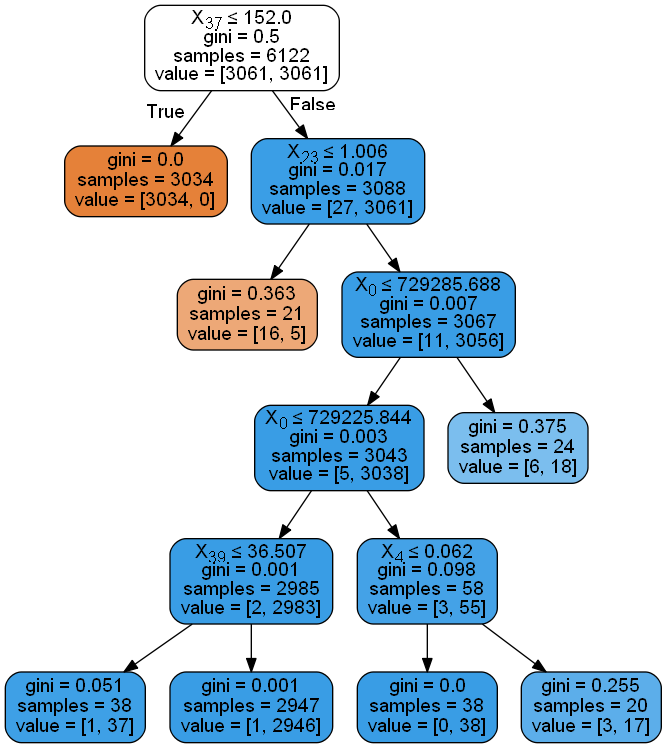

In [64]:
dibu_arb(clf_tree_osX1)

In [65]:
X1_train.columns[37]

'Ord_Loan_Payment_amount'

In [66]:
X1.columns[clf_tree_osX1.feature_importances_>0.10]

Index(['Ord_Loan_Payment_amount'], dtype='object')

In [67]:
X1.columns[clf_treeX1.feature_importances_>0.10]

Index(['Ord_Loan_Payment_amount'], dtype='object')

In [68]:
#El modelo continua dando unos resultados espectaculares, vamos a ver que sucede si eliminamos la variable 
#'Ord_Loan_Payment_amount'

In [69]:
X2=X1.drop(['Ord_Loan_Payment_amount'], axis=1)

In [70]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=0)

In [71]:
X2_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_treeX2=X2_clf_tree.fit(X2_train,y2_train)

In [72]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(44,57),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X2,os_y2=smo.fit_sample(X2_train, y2_train)
columns = X2_train.columns
os_X2 = pd.DataFrame(data=os_X2,columns=columns)
os_y2= pd.DataFrame(data=os_y2,columns=['account_loan_bin'])

In [73]:
osX2_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_tree_osX2=osX2_clf_tree.fit(os_X2,os_y2)

In [74]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX2,X2_train,y2_train, X2_test, y2_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX2,os_X2,os_y2, X2_test, y2_test)

Sin Oversampling
Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140
Con Oversampling
Datos de train:
El accuracy es 99.73864750081673 %
La precision es 99.64134333224649 %
El recall es 99.83665468801046 %
tn: 3050  fp: 11  fn: 5  tp: 3056
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


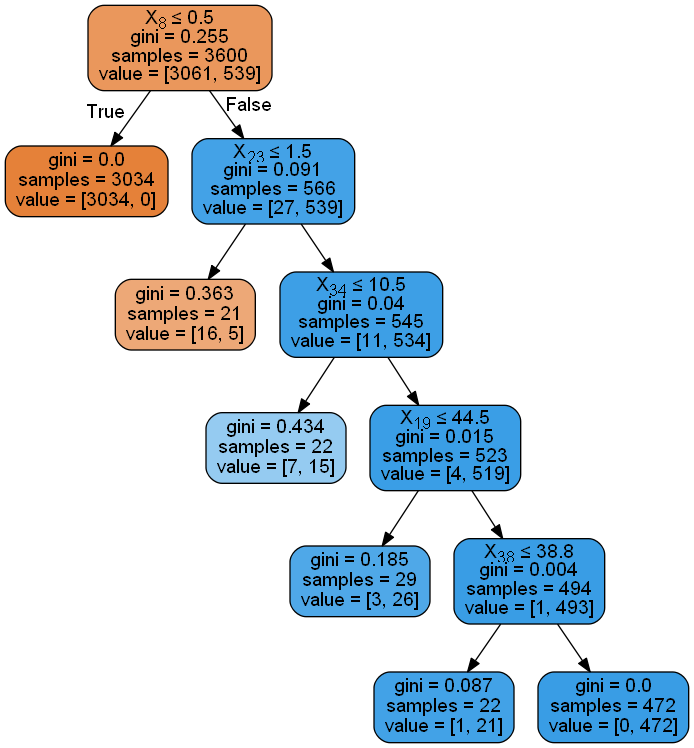

In [75]:
dibu_arb(clf_treeX2)

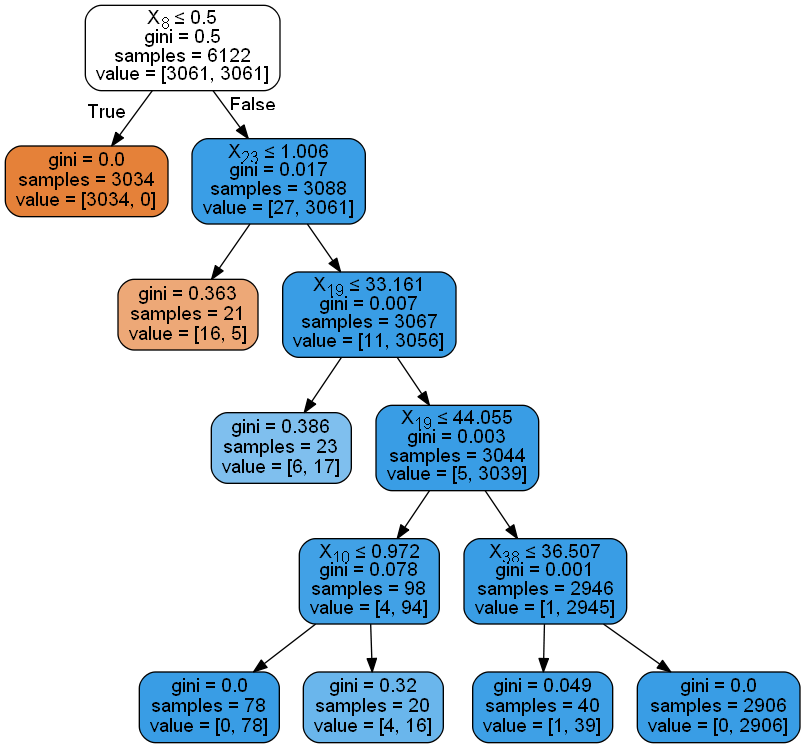

In [76]:
dibu_arb(clf_tree_osX2)

In [77]:
X2_train.columns[8]

'Ord_Loan_Payment'

In [78]:
X2.columns[clf_treeX2.feature_importances_>0.10]

Index(['Ord_Loan_Payment'], dtype='object')

In [79]:
X2.columns[clf_tree_osX2.feature_importances_>0.10]

Index(['Ord_Loan_Payment'], dtype='object')

In [80]:
#El modelo continua dando resultados espectaculares, vamos a ver que sucede si eliminamos la variable Ord_Loan_Payment

In [81]:
X3=X2.drop(['Ord_Loan_Payment'], axis=1)

In [82]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=0)

In [83]:
X3_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_treeX3=X3_clf_tree.fit(X3_train,y3_train)

In [84]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(43,56),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X3,os_y3=smo.fit_sample(X3_train, y3_train)
columns = X3_train.columns
os_X3 = pd.DataFrame(data=os_X3,columns=columns)
os_y3= pd.DataFrame(data=os_y3,columns=['account_loan_bin'])

In [85]:
osX3_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_tree_osX3=osX3_clf_tree.fit(os_X3,os_y3)

In [86]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX3,os_X3,os_y3, X3_test, y3_test)

Sin Oversampling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Oversampling
Datos de train:
El accuracy es 92.1920940868997 %
La precision es 94.95301079011486 %
El recall es 89.12120222149625 %
tn: 2916  fp: 145  fn: 333  tp: 2728
Datos de test:
El accuracy es 89.55555555555556 %
La precision es 66.66666666666666 %
El recall es 68.53146853146853 %
tn: 708  fp: 49  fn: 45  tp: 98


In [87]:
#Con Oversampling estoy "forzando" al modelo a generar más positivos  (tp y fp), y en este caso se ve perfectamente como
# con oversampling mejoro el recall (porque tengo más positivos), pero empeoro la precision porque no los estoy prediciendo
#correctamente

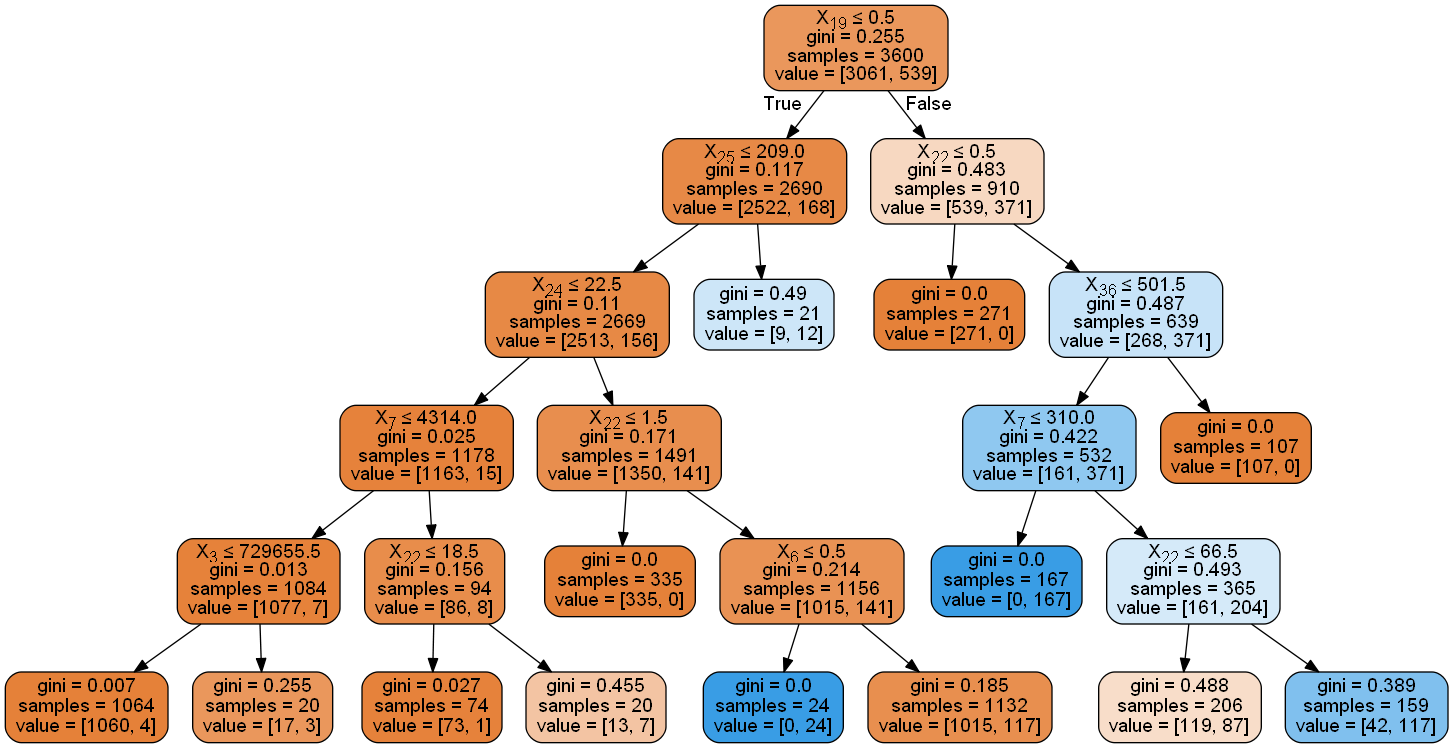

In [88]:
dibu_arb(clf_treeX3)

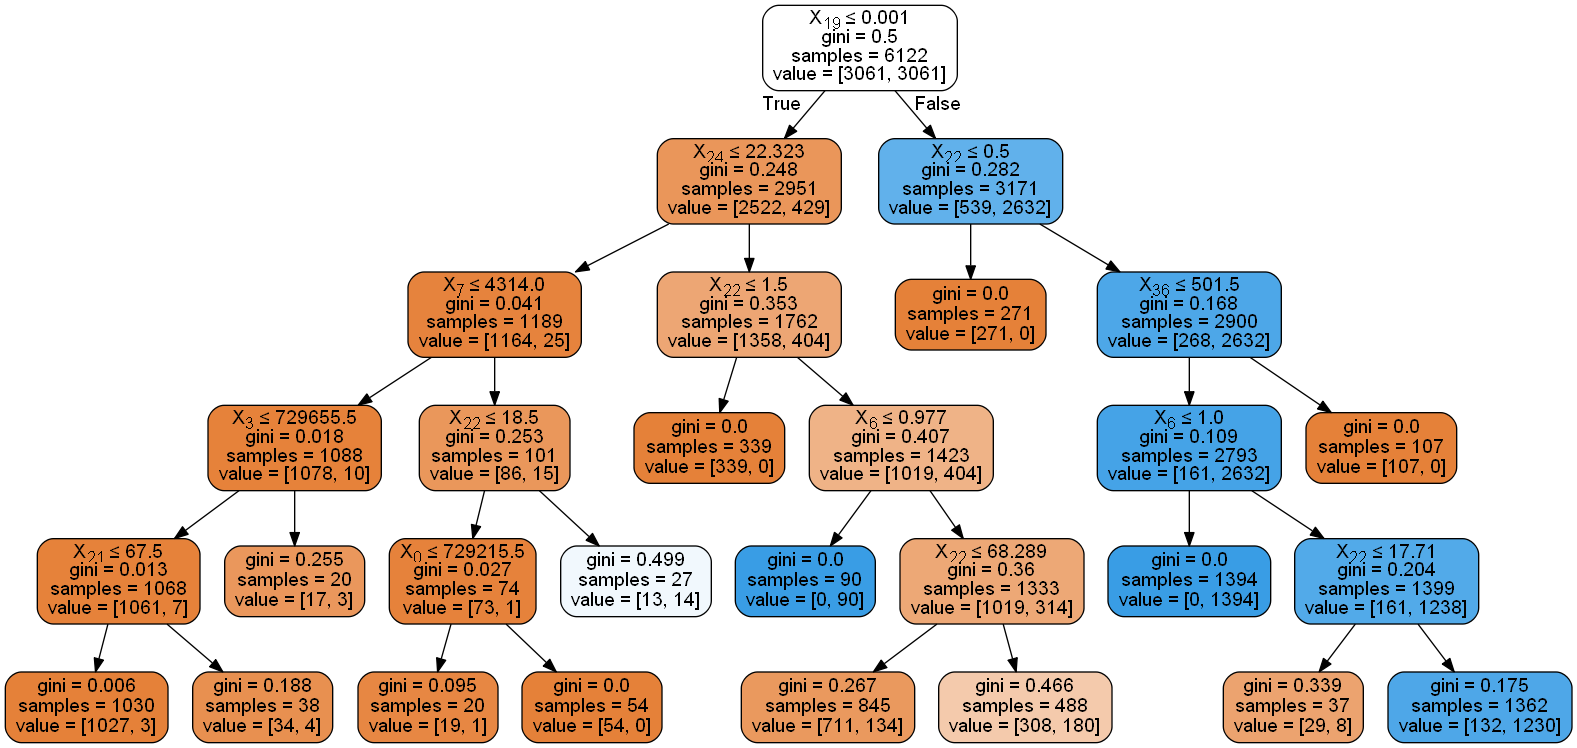

In [89]:
dibu_arb(clf_tree_osX3)

In [90]:
print(X3_train.columns[19])#Número de un tipo especial de reintegros
print(X3_train.columns[22])#Número de transferencias enviadas

Num_Type_VYBER
Num_Op_Remittances


In [91]:
X3.columns[clf_treeX3.feature_importances_>0.10]

Index(['Num_Type_VYBER', 'Num_Op_Remittances', 'Ord_Leasing_amount'], dtype='object')

In [92]:
X3.columns[clf_tree_osX3.feature_importances_>0.10]

Index(['Num_Type_VYBER', 'Num_Op_Remittances'], dtype='object')

In [93]:
clf_treeX3.feature_importances_

array([0.        , 0.        , 0.        , 0.00164631, 0.        ,
       0.        , 0.07409228, 0.08951546, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31780753,
       0.        , 0.        , 0.30827239, 0.        , 0.01728126,
       0.02150056, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1698842 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [94]:
print(df_original.corr()["account_loan_bin"])

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [95]:
#Después de eliminar las variables que más suenan a "préstamo", vamos a ver que sucede si eliminamos la variable Num_Type_VYBER,
#que es la de mayor importancia.Esta variable se corresponde con un tipo especial de reintegros

In [96]:
X4=X3.drop(['Num_Type_VYBER'], axis=1)

In [97]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.2, random_state=0)

In [98]:
X4_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_treeX4=X4_clf_tree.fit(X4_train,y4_train)

In [99]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(42,55),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X4,os_y4=smo.fit_sample(X4_train, y4_train)
columns = X4_train.columns
os_X4 = pd.DataFrame(data=os_X4,columns=columns)
os_y4= pd.DataFrame(data=os_y4,columns=['account_loan_bin'])

In [100]:
osX4_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)
clf_tree_osX4=clf_tree.fit(os_X4,os_y4)

In [101]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX4,X4_train,y4_train, X4_test, y4_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX4,os_X4,os_y4, X4_test, y4_test)

Sin Oversampling
Datos de train:
El accuracy es 91.33333333333333 %
La precision es 76.70588235294117 %
El recall es 60.48237476808905 %
tn: 2962  fp: 99  fn: 213  tp: 326
Datos de test:
El accuracy es 90.77777777777779 %
La precision es 76.78571428571429 %
El recall es 60.13986013986013 %
tn: 731  fp: 26  fn: 57  tp: 86
Con Oversampling
Datos de train:
El accuracy es 86.0829794184907 %
La precision es 86.4641795972268 %
El recall es 85.56027442012414 %
tn: 2651  fp: 410  fn: 442  tp: 2619
Datos de test:
El accuracy es 83.55555555555556 %
La precision es 48.78048780487805 %
El recall es 69.93006993006993 %
tn: 652  fp: 105  fn: 43  tp: 100


In [102]:
#Con los datos de X4 vemos que el oversampling genera el mismo efecto que en el caso de X3, mejora recall y empeora precision.
#Además, al eliminar la variable de 'Num_Type_VYBER' es destacable que el modelo que obtenemos tiende a generar un mayor número 
#de positivos, pero estos positivos resultan ser falsos positivos en su mayoría 

# ¿Puedo considerar que el oversampling no me está aportando nada?

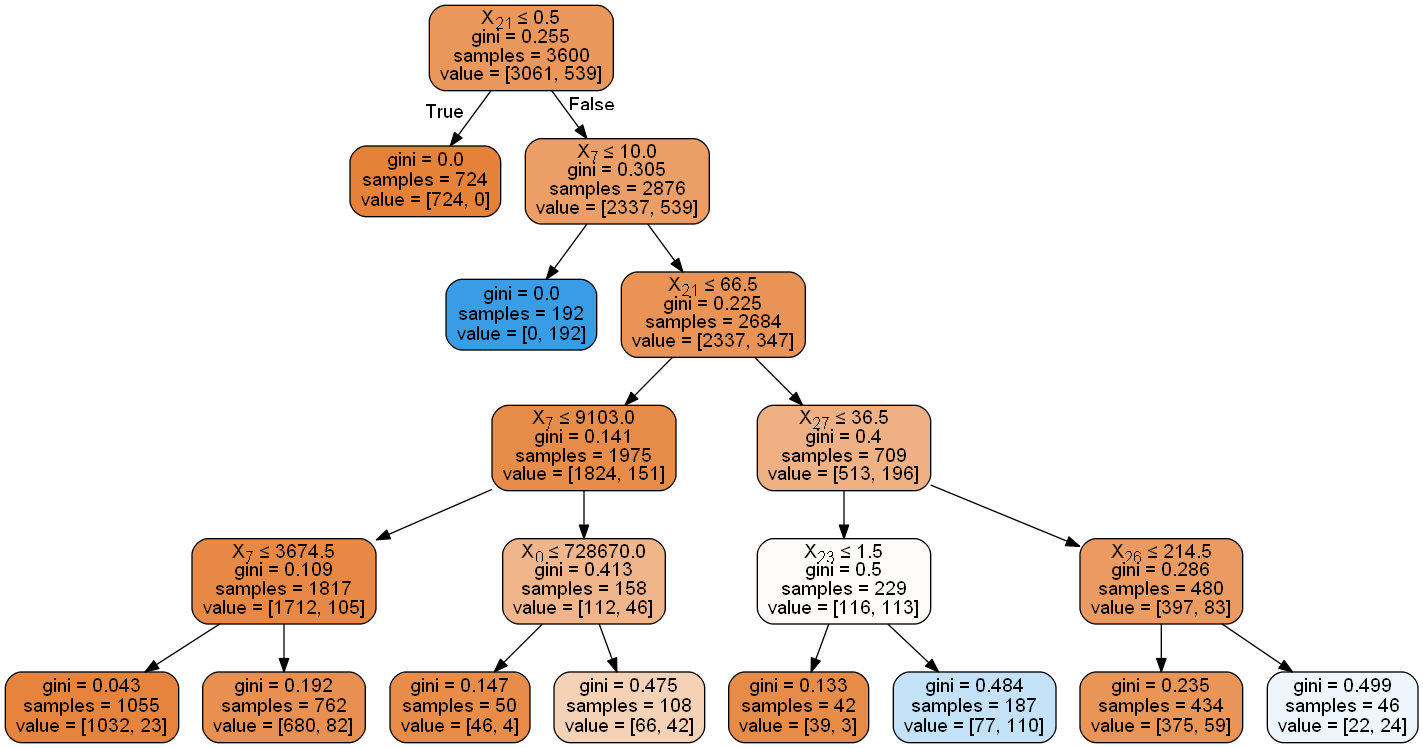

In [103]:
dibu_arb(clf_treeX4)

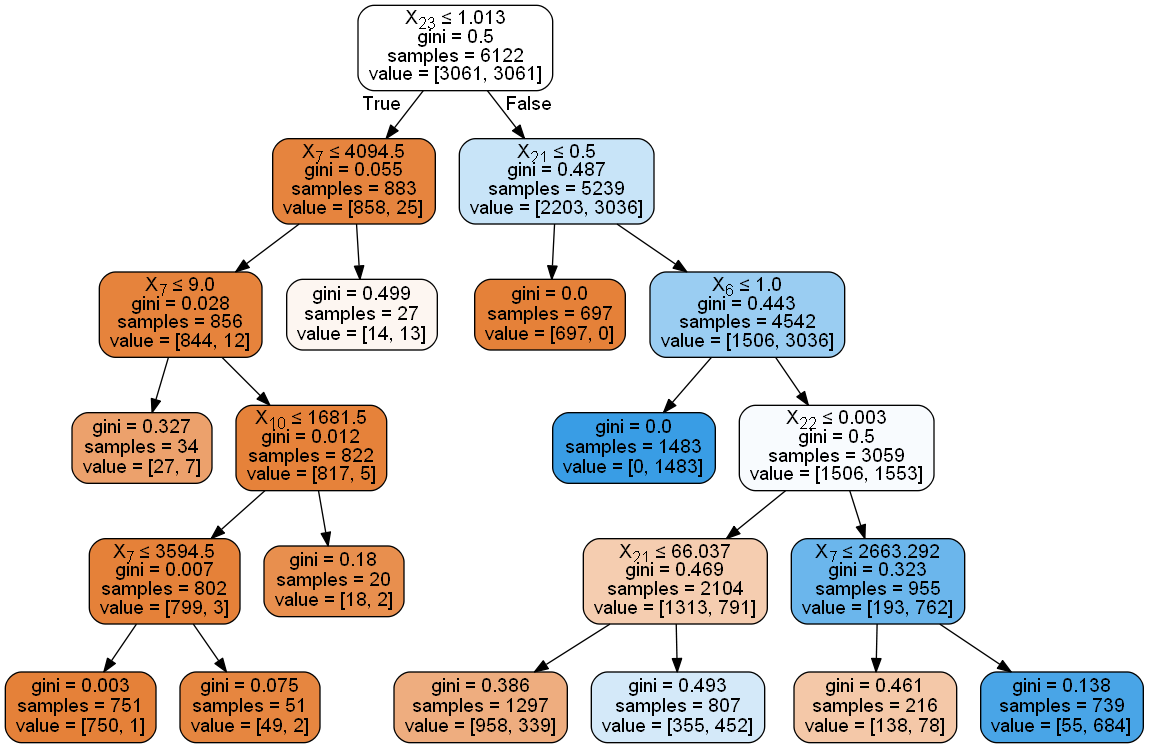

In [104]:
dibu_arb(clf_tree_osX4)

In [105]:
# Me quedo con el DataSet X3 no elimino la variable Num_Type_VYBER, ya que los resultados, aunque son peores, son ahora
# más razonables (teniendo)

In [106]:
# Vamos a seguir con árboles ya que es un modelo sencillo y que podría aportar explicabilidad

In [107]:
# Vamos a hacer scaling, aplicado a árboles no debería tener un gran impacto.

In [108]:
#Vamos a probar Robust Scaling, partiendo del DataFrame X3 (después de eliminar las variables que parece que contenían 
#la información de si una cuenta ha contratado préstamo o no lo ha contratado)
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
columns = X3.columns
rbs_scale = rbs.fit_transform(X3)
X=pd.DataFrame(rbs_scale,columns=columns)
X_rbs_sca=X.copy #Por si luego lo utilizamos
X.shape

(4500, 56)

In [109]:
X.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,-0.534615,0.468801,0.0,0.0,0.0,0.0,0.0,0.908203,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.120192,-0.268345,0.0,0.0,0.0,0.0,0.0,-0.115195,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.222115,0.613502,0.0,0.0,1.0,528.0,0.0,-0.483687,0.0,1.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.544231,0.429993,0.0,0.0,0.0,0.0,0.0,-0.076543,0.0,2.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.635577,-0.568076,0.0,0.0,0.0,0.0,0.0,0.087183,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [111]:
X_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)#Con scaling
clf_tree=X_clf_tree.fit(X_train,y_train)

In [112]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(X_clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80


In [113]:
# Los resultados con Robust Scaling no mejoran, así que vamos a probar con Standard Scaling aunque en un modelo de
# Decision Tree este modificación acostumbrará a tener poco impacto.

In [114]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
columns = X3.columns
scl_scale = scl.fit_transform(X3)
X=pd.DataFrame(scl_scale,columns=columns)
X_sta_sca=X.copy #Por si luego lo utilizamos
X.shape

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(4500, 56)

In [115]:
X.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,-0.741365,0.795247,-0.489186,-0.497221,-0.366159,-0.207962,0.458978,1.167602,3.492346,-0.566151,...,0.28269,-0.237356,-0.981504,0.981504,0.497221,-0.41421,-0.141229,-0.182469,-0.327957,-0.325875
1,0.039747,-0.382883,-0.489186,-0.497221,-0.366159,-0.207962,0.458978,-0.385762,-0.286340,-0.566151,...,0.28269,-0.237356,1.018844,-1.018844,0.497221,-0.41421,-0.141229,-0.182469,-0.327957,-0.325875
2,0.684934,1.026514,-0.489186,-0.497221,2.731052,0.511355,0.458978,-0.945079,-0.286340,1.281332,...,0.28269,-0.237356,1.018844,-1.018844,0.497221,-0.41421,-0.141229,-0.182469,-0.327957,-0.325875
3,1.292063,0.733224,-0.489186,-0.497221,-0.366159,-0.207962,0.458978,-0.327095,-0.286340,3.128815,...,0.28269,-0.237356,1.018844,-1.018844,0.497221,-0.41421,-0.141229,-0.182469,-0.327957,-0.325875
4,-0.931660,-0.861924,-0.489186,-0.497221,-0.366159,-0.207962,0.458978,-0.078583,-0.286340,-0.566151,...,0.28269,-0.237356,1.018844,-1.018844,0.497221,-0.41421,-0.141229,-0.182469,-0.327957,-0.325875


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [117]:
X_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)#Con scaling
clf_tree_=X_clf_tree.fit(X_train,y_train)

In [118]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Scaling
Datos de train:
El accuracy es 85.36111111111111 %
La precision es 51.63043478260869 %
El recall es 35.25046382189239 %
tn: 2883  fp: 178  fn: 349  tp: 190
Datos de test:
El accuracy es 85.11111111111111 %
La precision es 54.45544554455446 %
El recall es 38.46153846153847 %
tn: 711  fp: 46  fn: 88  tp: 55


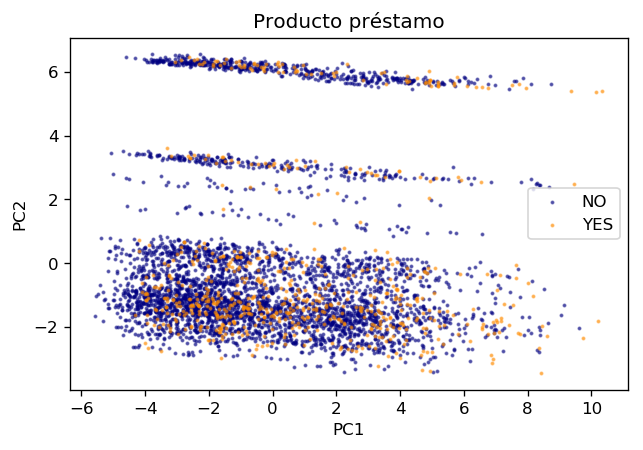

In [119]:
#Vamos a probar si con el scaling, cuando hacemos PCA podemos obtener una representación simple de los datos. 
#Sé que va a ser difícil pero lo probamos.
pca = PCA(n_components=2).fit_transform(X)
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='NO', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='YES', s=2, color='darkorange')
plt.legend()
plt.title('Producto préstamo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

In [120]:
#Del gráfico anterior no consigo sacar nada en claro
pca2 = PCA(n_components=2)
pca2.fit(X)
print(pca2.components_)
print(pca2.explained_variance_ratio_)

[[-0.30059209  0.031546    0.00220654  0.0305005   0.09095793  0.05712375
   0.02685215  0.01555704  0.02800105  0.10521173  0.07475941  0.02930079
  -0.01896022 -0.01866236 -0.01547583 -0.00382208 -0.02586574  0.0325454
   0.30983625  0.10990097  0.32363175  0.30145128  0.23613445  0.05281695
   0.19390217  0.30391841  0.06945784  0.2860118   0.17879615  0.00401835
   0.14357991  0.0359283   0.21736972  0.30856379  0.30145128  0.02508734
   0.0264544   0.02439825 -0.00518669 -0.00528221  0.03197488  0.03168417
  -0.02267096 -0.00193834  0.00193834  0.01381261 -0.02574604  0.02124859
   0.00513116 -0.00513116 -0.03054733  0.01711022  0.0263843   0.01401732
  -0.00774751  0.01038472]
 [ 0.03158493  0.01336152  0.00848238  0.016337   -0.0007066   0.01024506
  -0.0080896  -0.00373235  0.00466726 -0.00079595  0.00729584  0.34722566
  -0.22973515 -0.28186926 -0.24329998 -0.09053833 -0.27104559  0.3555224
  -0.02594534 -0.00462541 -0.0295986  -0.02649121 -0.02065813 -0.02051364
  -0.00433421

In [121]:
#De las componentes principales de momento tampoco sacamos ninguna conclusión, pero al haber escalado los datos ahora obtenemos un dato 
#más razonable de variabilidad explicada

In [122]:
#Standard Scaling tampoco ha funcionado mejor que sin scaling. Aplicamos scaling sólo a las variables numéricas
print(X3.columns)
print(X3.shape)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Leasing', 'Ord_Empty',
       'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative', 'Ord_Leasing_amount', 'ratio_urban_inhabitants',
       'unemployment_rate_95', 'unemployment_rate_96', 'crimes_95_ratio',
       'crimes_96_ratio', 'entrepreneurs_ratio', 'account_disponent_bin_0',
       'a

In [123]:
#Separamos las variables numéricas de las que consideramos categóricas
X3_cat=X3[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
X3_num=X3[['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Leasing', 'Ord_Empty',
       'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative', 'Ord_Leasing_amount', 'ratio_urban_inhabitants',
       'unemployment_rate_95', 'unemployment_rate_96', 'crimes_95_ratio',
       'crimes_96_ratio', 'entrepreneurs_ratio']]

In [124]:
#Probamos con el Robust Scaling
columns = X3_num.columns
X3_scale = rbs.fit_transform(X3_num)
X3_scale=pd.DataFrame(X3_scale,columns=columns)
X = pd.concat([X3_scale,X3_cat], axis = 1)
X.shape
X_sca_num=X.copy #Guardamos este DataFrame por si la utilizamos posteriormente

In [125]:
X.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,-0.534615,0.468801,0.0,0.0,0.0,0.0,0.0,0.908203,1.0,0.0,...,1,0,0,1,1,0,0,0,0,0
1,-0.120192,-0.268345,0.0,0.0,0.0,0.0,0.0,-0.115195,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0
2,0.222115,0.613502,0.0,0.0,1.0,528.0,0.0,-0.483687,0.0,1.0,...,1,0,1,0,1,0,0,0,0,0
3,0.544231,0.429993,0.0,0.0,0.0,0.0,0.0,-0.076543,0.0,2.0,...,1,0,1,0,1,0,0,0,0,0
4,-0.635577,-0.568076,0.0,0.0,0.0,0.0,0.0,0.087183,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [127]:
X_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)#Con scaling
clf_tree_=X_clf_tree.fit(X_train,y_train)

In [128]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Robust Scaling sólo en variables numéricas")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Robust Scaling sólo en variables numéricas
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80


In [129]:
#En este caso, el robust scaling tampoco mejora los resultados que teníamos originalmente. Probamos otra alternativa

In [130]:
#Probamos con min-max scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

In [131]:
columns = X3_num.columns
X3_scale = minmax.fit_transform(X3_num)
X3_scale=pd.DataFrame(X3_scale,columns=columns)
X = pd.concat([X3_scale,X3_cat], axis = 1)
X.shape
Xminmax=X.copy

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [133]:
X_clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5,random_state=0)#Con scaling
clf_tree_=X_clf_tree.fit(X_train,y_train)

In [134]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Scaling
Datos de train:
El accuracy es 84.94444444444444 %
La precision es 20.0 %
El recall es 0.1855287569573284 %
tn: 3057  fp: 4  fn: 538  tp: 1
Datos de test:
El accuracy es 84.0 %
La precision es 0.0 %
El recall es 0.0 %
tn: 756  fp: 1  fn: 143  tp: 0


In [135]:
#Con scaling MinMax el modelo casi no genera predicciones positivas y el accuracy se obtiene por un modelo que básicamente
#predice en test que la cuenta no contrata préstamo y al estar las clases desbalanceadas obtenemos ese acuraccy, pero muy mal
#recall y precision

# Hasta el momento hemos visto que en el dataset que habíamos generado 
habían 3 variables que "contenían" la información de la variable que queríamos predecir y también hemos visto que, en el caso de Decision Trees, las técnicas de Oversampling y de Scaling tal y como las hemos aplicado no mejoran los modelos iniciales.

# A continuación trabajamos sobre las features numéricas

In [136]:
print(X3_num.columns)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Leasing', 'Ord_Empty',
       'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative', 'Ord_Leasing_amount', 'ratio_urban_inhabitants',
       'unemployment_rate_95', 'unemployment_rate_96', 'crimes_95_ratio',
       'crimes_96_ratio', 'entrepreneurs_ratio'],
      dtype='object')


In [137]:
#A partir del DataFrame X3 creamos un DataFrame que contenga el log natural de las variables numéricas
cols = X3_num.columns
X3_log=pd.DataFrame(X3_num,columns=columns)#También podríamos hacer un copy del DF

In [138]:
#Calculamos el logaritmo de las variables que consideramos numéricas
cols=X3_num.columns
for col in cols:
    X3_log[col]=X3_log[col]+1.1 #Para evitar negativos al aplicar el logaritmo añadimos 1.1
    X3_log[col]=np.log(X3_log[col])

In [139]:
X3_log.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,Num_Sym_Statement,Num_Sym_IntDep,Balance_in_negative,Ord_Leasing_amount,ratio_urban_inhabitants,unemployment_rate_95,unemployment_rate_96,crimes_95_ratio,crimes_96_ratio,entrepreneurs_ratio
0,13.498201,13.484813,0.741937,0.741937,0.095310,0.095310,0.741937,8.801936,0.741937,0.095310,...,3.914021,4.009150,0.09531,6.375195,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
1,13.498792,13.474528,0.741937,0.741937,0.095310,0.095310,0.741937,7.567397,0.095310,0.095310,...,3.586293,3.613617,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
2,13.499281,13.486819,0.741937,0.741937,0.741937,6.271177,0.741937,5.468482,0.095310,0.741937,...,3.182212,3.370738,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
3,13.499740,13.484274,0.741937,0.741937,0.095310,0.095310,0.741937,7.655438,0.095310,1.131402,...,2.572612,2.895912,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
4,13.498056,13.470315,0.741937,0.741937,0.095310,0.095310,0.741937,7.960707,0.095310,0.095310,...,3.972177,3.990834,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436


In [140]:
#Hemos conseguido diminuir la variabilidad de las features
X3_log.describe()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,Num_Sym_Statement,Num_Sym_IntDep,Balance_in_negative,Ord_Leasing_amount,ratio_urban_inhabitants,unemployment_rate_95,unemployment_rate_96,crimes_95_ratio,crimes_96_ratio,entrepreneurs_ratio
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,...,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,13.498762,13.477844,3.200962,3.270834,0.171756,0.813928,0.590701,6.047451,0.144310,0.283122,...,3.372861,3.580879,0.212690,0.660616,4.213332,1.266006,1.403430,0.127022,0.128640,0.096185
std,0.000758,0.008757,5.027065,5.086630,0.208800,2.046884,0.295340,3.537753,0.171144,0.320038,...,0.761823,0.626742,0.509018,1.980893,0.284602,0.509074,0.519244,0.014687,0.016954,0.000548
min,13.497459,13.459089,0.741937,0.741937,0.095310,0.095310,0.095310,0.095310,0.095310,0.095310,...,0.095310,0.095310,0.095310,0.095310,3.555348,0.329304,0.425268,0.107547,0.109703,0.095436
25%,13.497953,13.471436,0.741937,0.741937,0.095310,0.095310,0.095310,0.095310,0.095310,0.095310,...,3.049273,3.261935,0.095310,0.095310,3.985273,0.993252,1.118415,0.115781,0.115597,0.095752
50%,13.498964,13.478284,0.741937,0.741937,0.095310,0.095310,0.741937,7.809785,0.095310,0.095310,...,3.437208,3.613617,0.095310,0.095310,4.162003,1.353255,1.519513,0.123438,0.123949,0.096135
75%,13.499381,13.485406,0.741937,0.741937,0.095310,0.095310,0.741937,8.435191,0.095310,0.741937,...,4.009150,4.096010,0.095310,0.095310,4.462454,1.631199,1.773256,0.133458,0.133664,0.096464
max,13.499961,13.492396,13.494812,13.500462,0.741937,9.433892,1.131402,9.607982,0.741937,1.131402,...,4.264087,5.258016,4.829113,8.512442,4.616110,2.132982,2.351375,0.157947,0.167419,0.097939


In [141]:
#Creamos un DataFrame a partir del DataFrame X3 (una vez eliminadas las 3 variables que contenían la información de la variable
#a predecir), aplicando logaritmo a las variables que consideramos numéricas y dejando las categóricas igual.
X_log= pd.concat([X3_log,X3_cat], axis = 1)

In [142]:
X_log.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,13.498201,13.484813,0.741937,0.741937,0.095310,0.095310,0.741937,8.801936,0.741937,0.095310,...,1,0,0,1,1,0,0,0,0,0
1,13.498792,13.474528,0.741937,0.741937,0.095310,0.095310,0.741937,7.567397,0.095310,0.095310,...,1,0,1,0,1,0,0,0,0,0
2,13.499281,13.486819,0.741937,0.741937,0.741937,6.271177,0.741937,5.468482,0.095310,0.741937,...,1,0,1,0,1,0,0,0,0,0
3,13.499740,13.484274,0.741937,0.741937,0.095310,0.095310,0.741937,7.655438,0.095310,1.131402,...,1,0,1,0,1,0,0,0,0,0
4,13.498056,13.470315,0.741937,0.741937,0.095310,0.095310,0.741937,7.960707,0.095310,0.095310,...,1,0,1,0,1,0,0,0,0,0


In [143]:
#Vamos a crear un nuevo DataFrame binarizando las variables que tienen el número de operaciones (pasan de tener el número de 
#operaciones a decir si la cuenta ha realizado ese tipo de operativa o no) y eliminando las columnas que contienen
#el sufijo "_amount" (sólo queremos reflejar si se ha realizado un tipo de operativa o no se ha realizado)

col_to_bin=['Ord_Insurance', 'Ord_Household_Payment','Ord_Leasing', 'Ord_Empty','Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances','Num_Op_Collection', 'Num_Op_CashCredit', 
       'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal','Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative']

col_out=['Ord_Insurance_amount','Ord_Household_Payment_amount','Ord_Empty_amount', 'Ord_Leasing_amount']

In [144]:
cols = X3.columns
X3_bin=pd.DataFrame(X3,columns=cols)
X3_bin=X3_bin.drop(col_out, axis=1)#Eliminamos las columnas de amount
X3_bin=X3_bin.drop(col_to_bin, axis=1)#Eliminamos las columnas a binarizar

In [145]:
X3_bin.shape

(4500, 30)

In [146]:
#Definimos el dataset que queremos binarizar
X3_to_bin=X3[['Ord_Insurance', 'Ord_Household_Payment','Ord_Leasing', 'Ord_Empty','Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances','Num_Op_Collection', 'Num_Op_CashCredit', 
       'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal','Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative']]

In [147]:
def binario(x):
    if x>0:
        x=1
    else:
        x=0
    return x

In [148]:
for col in col_to_bin:
    X3_to_bin[col]=X3_to_bin[col].apply(binario)

C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [149]:
X3_to_bin=X3_to_bin.astype(str)
X3_to_bin=pd.get_dummies(X3_to_bin)

# ¿Porque hay algunas columnas que no se duplican con el get_dummies?

In [150]:
#Creamos un DataFrame a partir del DataFrame X3 (una vez eliminadas las 3 variables que conteníanla información de la variable
#dependiente), binarizando las variables que contaban el número de operaciones.
X_bin= pd.concat([X3_bin,X3_to_bin], axis = 1)

In [151]:
X_bin.shape

(4500, 69)

In [152]:
df_original.head()

,Unnamed: 0,district_id,account_id,frequency,Date_Account,client_id_owner,client_id_disponent,sex_owner,birth_owner,sex_disponent,...,Num_Sym_Pension,Num_Sym_Insurance,Num_Sym_NegBal,Num_Sym_Household,Num_Sym_Statement,Num_Sym_IntDep,Num_Sym_LoanPayment,Balance_in_negative,account_disponent_bin,account_loan_bin
0,1,1,1938,Monthly,728104,2354,NaN,M,718421,NaN,...,0,0,0,50,49,54,0,0,0,0
1,2,1,1562,Monthly,728535,1894,NaN,F,711070,NaN,...,0,0,0,36,35,36,0,0,0,0
2,3,1,7099,Monthly,728891,8568,NaN,F,719864,NaN,...,0,24,0,24,23,28,7,0,0,1
3,4,1,2316,Monthly,729226,2802,NaN,F,718034,NaN,...,0,0,0,13,12,17,0,0,0,0
4,5,1,1570,Monthly,727999,1903,NaN,F,708081,NaN,...,57,0,0,53,52,53,0,0,0,0


# Con los nuevos DataFrames de features vamos a intentar encontrar el mejor Decision Tree y ver cuales son las variables más significativas 

In [153]:
#Los DataFrames con los que vamos a trabajar son:
#X_orig: El Dataframe con el que habíamos trabajado antes eliminando 3 variables, también lo llamábamos X3.
X=X3
#X_log: Es el Dataframe X_orig pero haciendo el logaritmo natural a las variables numéricas
#X_bin: Es el Dataframe X_orig pero binarizando las variables que contaban cuantas operaciones de cada tipo se habían realizado
#en cada cuenta, ahora decimos si la cuenta tiene ese tipo de operativa o no, y eliminando las variables que cuantificaban los
#importes de dicha operativa

In [154]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [155]:
#Inicialmente pensaba considerar como única métrica la precisión (quería que el modelo minimizase los falsos positivos,
#pero en vista de los resultados de los modelos anteriores, en los que el recall (el % de positivos que acierto) 
#puede ser muy bajo voy a comenzar a monitorizar también el F1 Score 

In [156]:
#Incluimos la métrica del F1 Score en la evaluación de los modelos
def eval_modelo_2 (clf,X_train,y_train, X_test,y_test):
    print("Datos de train:")
    print("El accuracy es",accuracy_score(y_train,clf.predict(X_train))*100,"%")
    print("La precision es",precision_score(y_train,clf.predict(X_train))*100, "%")
    print("El recall es",recall_score(y_train,clf.predict(X_train))*100, "%")
    print("El F1 Score es",f1_score(y_train,clf.predict(X_train))*100,"%")
    tn, fp, fn, tp=confusion_matrix(y_train,clf.predict(X_train)).ravel()
    print("tn:",tn," fp:",fp," fn:",fn," tp:",tp)
    print("Datos de test:")
    print("El accuracy es",accuracy_score(y_test,clf.predict(X_test))*100,"%")
    print("La precision es",precision_score(y_test,clf.predict(X_test))*100, "%")
    print("El recall es",recall_score(y_test,clf.predict(X_test))*100,"%")
    print("El F1 Score es",f1_score(y_test,clf.predict(X_test))*100,"%")
    tn_t, fp_t, fn_t, tp_t=confusion_matrix(y_test,clf.predict(X_test)).ravel()
    print("tn:",tn_t," fp:",fp_t," fn:",fn_t," tp:",tp_t)      

In [157]:
#Vamos a definir la parrilla para realizar Randomized Grid Search

# Máximo número de niveles en el árbol. Damos una distribución con mayor probabilidad en valores pequeños
max_depth1 = [int(x) for x in np.linspace(2, 20, num = 10)]#"Sobreponderamos" árboles con poca profundidad
max_depth2 =[int(x) for x in np.linspace(30, 100, num = 4)]
max_depth=max_depth1 + max_depth2

# Mínimo número de observaciones en cada hoja.Damos una distribución con mayor probabilidad en valores pequeños
min_samples_leaf_1 = [int(x) for x in np.linspace(5, 50, num = 4)]
min_samples_leaf_2 = [int(x) for x in np.linspace(60, 100, num = 10)]
min_samples_leaf=min_samples_leaf_1+min_samples_leaf_2


In [158]:
max_depth

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 53, 76, 100]

In [159]:
min_samples_leaf

[5, 20, 35, 50, 60, 64, 68, 73, 77, 82, 86, 91, 95, 100]

In [160]:
# Creamos la grid aleatoria
random_grid = {'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }

In [161]:
clf_tree = DecisionTreeClassifier(random_state=0)
#Creamos una versión para optimizar la precision
clf_tree_random_p= RandomizedSearchCV(random_state=0,estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="precision")
#Creamos una versión para optimizar el F1 Score
clf_tree_random_f1= RandomizedSearchCV(random_state=0,estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="f1")

In [162]:
#Comenzamos por el DataFrame X (el X3 anterior)
#Generamos conjuntos de train y el de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [163]:
clf_tree_random_p.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 53, 76, 100], 'min_samples_leaf': [5, 20, 35, 50, 60, 64, 68, 73, 77, 82, 86, 91, 95, 100]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='precision', verbose=0)

In [164]:
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 10}


In [165]:
#Trabajamos ahora con el mejor modelo encontrado en el Randomized Search, optimizando la precision. Entrenamos ahora el modelo
#con todos los datos de train y luego lo evaluaremos con un conjunto de test no utilizado en la estimación
clf_tree_p = clf_tree_random_p.best_estimator_
clf_tree_p.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [166]:
eval_modelo_2 (clf_tree_p,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 95.72222222222221 %
La precision es 91.93899782135077 %
El recall es 78.29313543599258 %
El F1 Score es 84.5691382765531 %
tn: 3024  fp: 37  fn: 117  tp: 422
Datos de test:
El accuracy es 92.11111111111111 %
La precision es 81.03448275862068 %
El recall es 65.73426573426573 %
El F1 Score es 72.58687258687257 %
tn: 735  fp: 22  fn: 49  tp: 94


In [167]:
#Parece que el modelo anterior produce overfitting

In [168]:
X.columns[clf_tree_p.feature_importances_>0.10]
#Las variables que obtenemos de este árbol que parece que produce overfitting son las que habíamos visto anteriormente 

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [169]:
#Vemos ahora los resultados con la optimización realizada sobre F1 Score

clf_tree_random_f1.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_train,y_train)

eval_modelo_2 (clf_tree_f1,X_train,y_train, X_test,y_test)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 18}
Datos de train:
El accuracy es 97.91666666666666 %
La precision es 94.78764478764478 %
El recall es 91.09461966604823 %
El F1 Score es 92.90444654683066 %
tn: 3034  fp: 27  fn: 48  tp: 491
Datos de test:
El accuracy es 93.55555555555556 %
La precision es 84.5528455284553 %
El recall es 72.72727272727273 %
El F1 Score es 78.19548872180452 %
tn: 738  fp: 19  fn: 39  tp: 104


In [170]:
#Atención: obtengo mejor precision en el modelo que optimiza F1 Score que en el que optimiza Precision. Dado que el coste  
#computacional es bajo, creo que va a ser mejor aplicar GridSearch CV en lugar de RandomizedGridSearchCV, para no obtener 
#resultados incoherentes

In [171]:
#Comparando el modelo que optimizamos el F1 Score, respecto al que optimizamos la precision, creo que es mejor el que optimiza
#el F1 Score porque la precision puede bajar un poco, el recall aumenta de forma más significativa. Esto lo consigue 
#generando un mayor número de positivos

In [172]:
#Tomamos el árbol anterior como árbol de referencia ya que ofrece el mejor balance de precision-recall
clf_tree_best=clf_tree_f1

In [173]:
X.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [174]:
#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3,random_state=0)
clf_tree.fit(X_train,y_train)
eval_modelo_2(clf_tree,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 90.94444444444446 %
La precision es 69.25858951175407 %
El recall es 71.05751391465677 %
El F1 Score es 70.14652014652015 %
tn: 2891  fp: 170  fn: 156  tp: 383
Datos de test:
El accuracy es 89.11111111111111 %
La precision es 65.73426573426573 %
El recall es 65.73426573426573 %
El F1 Score es 65.73426573426573 %
tn: 708  fp: 49  fn: 49  tp: 94


In [175]:
clf_tree_benchmark=clf_tree

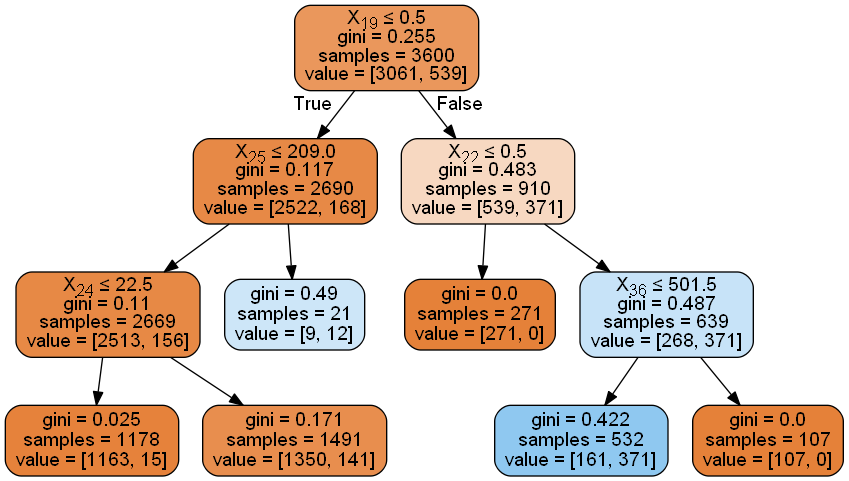

In [176]:
dibu_arb(clf_tree_benchmark)

In [177]:
print(X_train.columns[19])
print(X_train.columns[25])
print(X_train.columns[22])
print(X_train.columns[24])
print(X_train.columns[36])

Num_Type_VYBER
Num_Op_WithdrawalCash
Num_Op_Remittances
Num_Op_CashCredit
Ord_Leasing_amount


In [178]:
#Interpretando el árbol anterior, lo que obtenemos es que, mayoritariamente, las cuentas que contratan préstamos son las que:
#--Num_Type_Viber > 0.5 (reintegros del tipo especial Vyber)
#--Num_Op_Remittances > 0.5 (envios/transferencias a otros bancos). Este podría ser un indicador de la solvencia y por tanto
#le encuentro sentido a su aparición
#--Ord_Leasing Amount<=501,5 (cargos automáticos por Leasing)

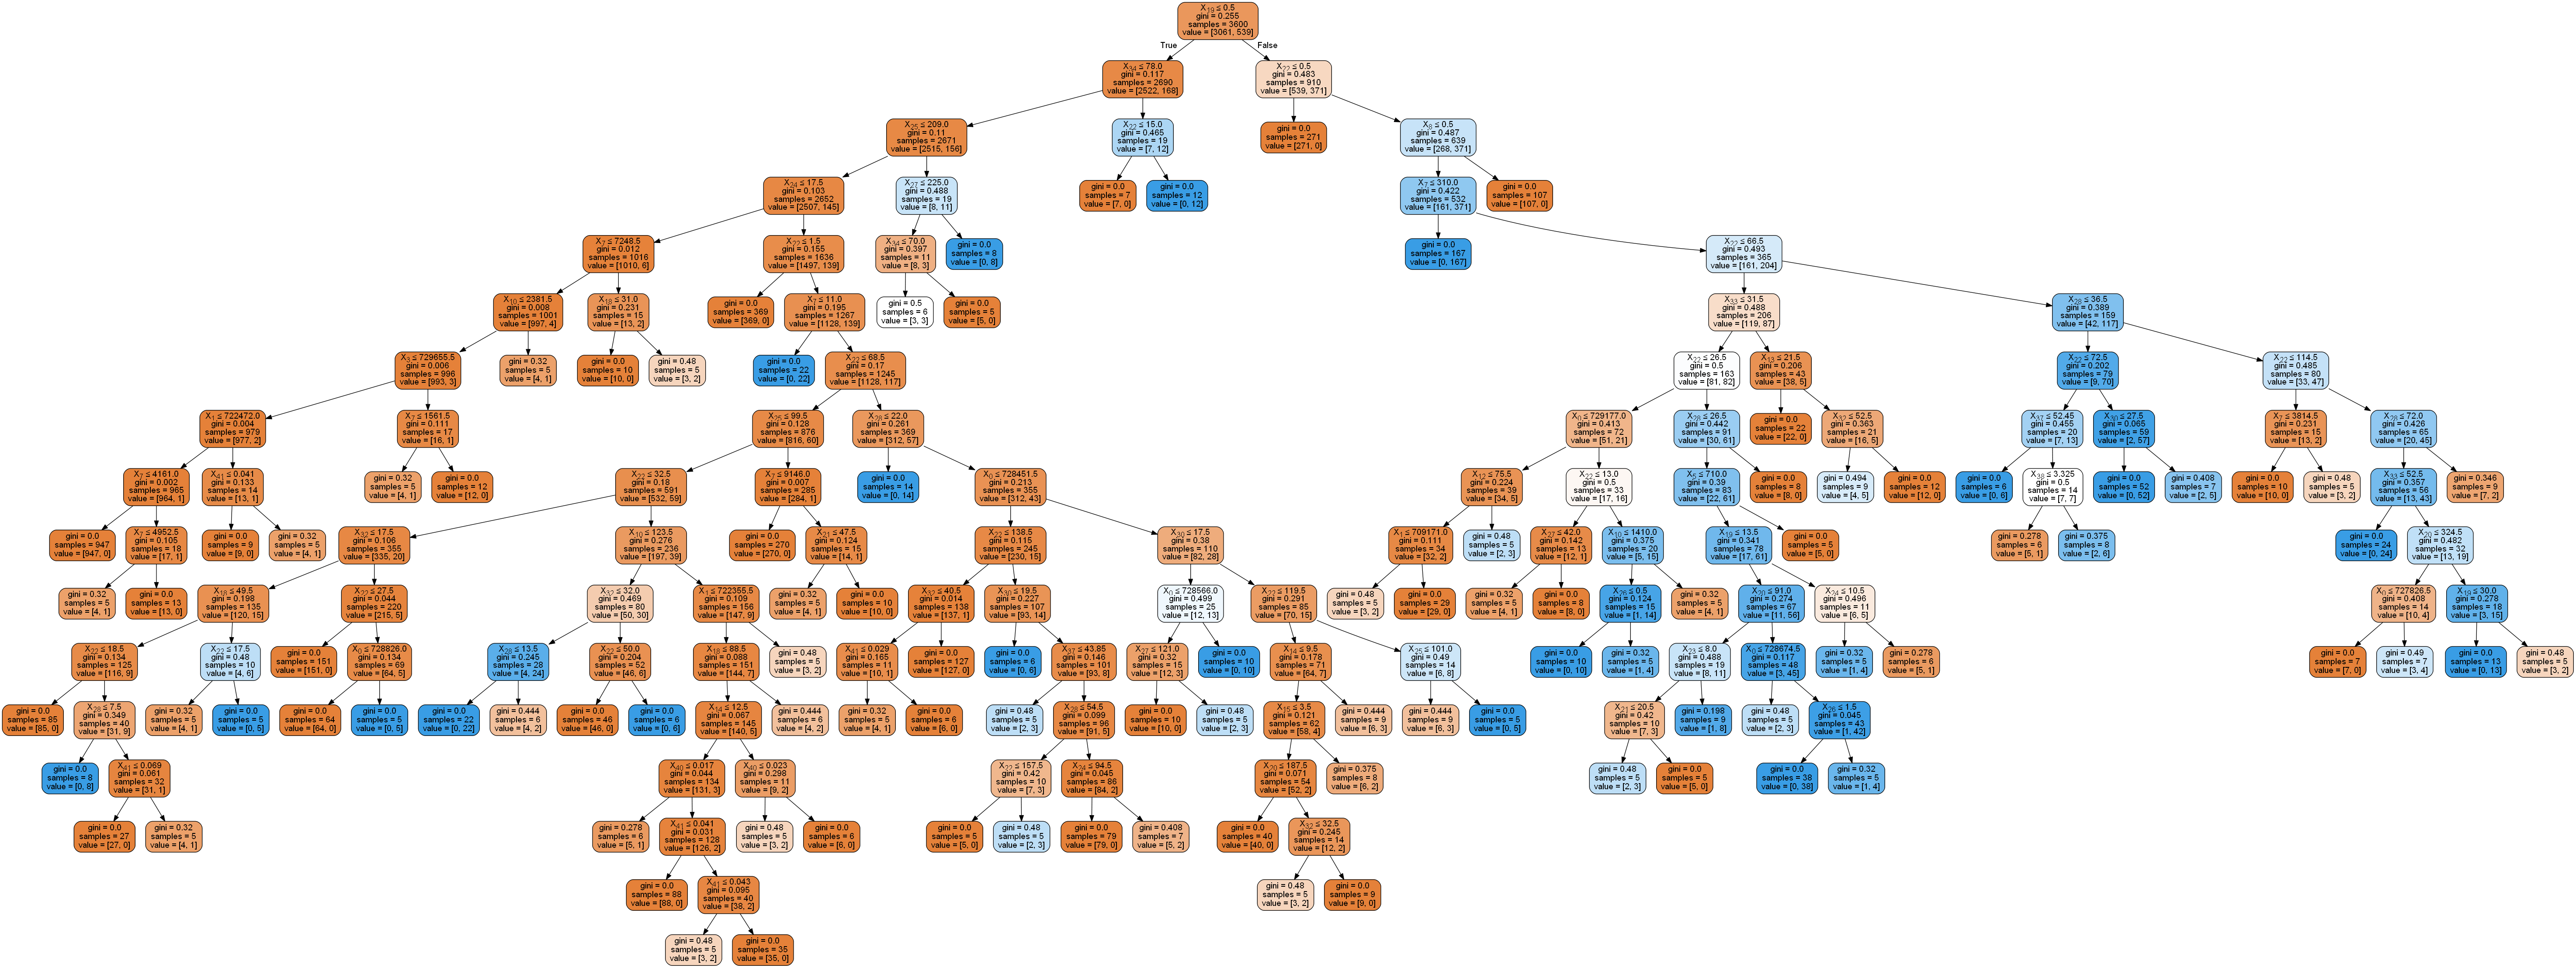

In [179]:
dibu_arb(clf_tree_best)

In [180]:
X.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [181]:
#plot_importance(clf_tree_f1)
#pyplot.show()

In [182]:
#De momento parece que la información aportada por los modelos obtenidos con randomized search y un modelo sencillo con
#criterio experto aportan resultados bastante similares

In [183]:
#Comenzamos por el DataFrame X_log
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y, test_size=0.2, random_state=0)

In [184]:
#Vamos a seguir trabajando con árboles por lo que, como en el caso del scaling, no esperamos mejoras significativas

In [185]:
clf_tree_random_p.fit(X_log_train, y_log_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 10}


In [186]:
clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_log_train,y_log_train)
eval_modelo_2(clf_tree_p,X_log_train, y_log_train,X_log_test, y_log_test)

Datos de train:
El accuracy es 95.72222222222221 %
La precision es 91.93899782135077 %
El recall es 78.29313543599258 %
El F1 Score es 84.5691382765531 %
tn: 3024  fp: 37  fn: 117  tp: 422
Datos de test:
El accuracy es 92.11111111111111 %
La precision es 81.03448275862068 %
El recall es 65.73426573426573 %
El F1 Score es 72.58687258687257 %
tn: 735  fp: 22  fn: 49  tp: 94


In [187]:
X.columns[clf_tree_p.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [188]:
#Optimizamos ahora el F1 Score
clf_tree_random_f1.fit(X_log_train, y_log_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 18}


In [189]:
clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_log_train, y_log_train)
eval_modelo_2 (clf_tree_f1,X_log_train, y_log_train,X_log_test, y_log_test)

Datos de train:
El accuracy es 97.91666666666666 %
La precision es 94.78764478764478 %
El recall es 91.09461966604823 %
El F1 Score es 92.90444654683066 %
tn: 3034  fp: 27  fn: 48  tp: 491
Datos de test:
El accuracy es 93.44444444444444 %
La precision es 83.87096774193549 %
El recall es 72.72727272727273 %
El F1 Score es 77.90262172284645 %
tn: 737  fp: 20  fn: 39  tp: 104


In [190]:
#Atención: obtengo mejor precision en el modelo que optimiza F1 Score que en el que optimiza Precision. Dado que el coste  
#computacional es bajo, creo que va a ser mejor aplicar GridSearch CV en lugar de RandomizedGridSearchCV, para no obtener 
#resultados incoherentes

In [191]:
X_log.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [192]:
#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3,random_state=0)
clf_tree.fit(X_log_train, y_log_train)
eval_modelo_2(clf_tree,X_log_train, y_log_train,X_log_test, y_log_test)

Datos de train:
El accuracy es 90.94444444444446 %
La precision es 69.25858951175407 %
El recall es 71.05751391465677 %
El F1 Score es 70.14652014652015 %
tn: 2891  fp: 170  fn: 156  tp: 383
Datos de test:
El accuracy es 89.11111111111111 %
La precision es 65.73426573426573 %
El recall es 65.73426573426573 %
El F1 Score es 65.73426573426573 %
tn: 708  fp: 49  fn: 49  tp: 94


In [193]:
X_log.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [194]:
#Vemos que hemos obtenido features muy similares probando con técnicas más complejas como Randomized Search y con 
#criterio experto o lo que podríamos haber obtenido a partir de un modelo benchmark inicial

In [195]:
#Seguimos con el DataFrame X_bin, en el que hemos binarizado las variables de 
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y, test_size=0.2, random_state=0)

In [196]:
clf_tree_random_p.fit(X_bin_train, y_bin_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 35, 'max_depth': 76}


In [197]:
clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_bin_train,y_bin_train)
eval_modelo_2(clf_tree_p,X_bin_train, y_bin_train,X_bin_test, y_bin_test)

Datos de train:
El accuracy es 91.58333333333334 %
La precision es 78.0952380952381 %
El recall es 60.85343228200371 %
El F1 Score es 68.40458811261732 %
tn: 2969  fp: 92  fn: 211  tp: 328
Datos de test:
El accuracy es 89.44444444444444 %
La precision es 71.81818181818181 %
El recall es 55.24475524475524 %
El F1 Score es 62.450592885375485 %
tn: 726  fp: 31  fn: 64  tp: 79


In [198]:
X_bin.columns[clf_tree_p.feature_importances_>0.10]

Index(['Ord_Leasing_1', 'Num_Type_VYBER_1', 'Num_Op_Remittances_0'], dtype='object')

In [199]:
#Optimizamos ahora el F1 Score
clf_tree_random_f1.fit(X_bin_train, y_bin_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 4}


In [200]:
clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_bin_train, y_bin_train)
eval_modelo_2 (clf_tree_f1,X_bin_train, y_bin_train,X_bin_test, y_bin_test)

Datos de train:
El accuracy es 91.69444444444444 %
La precision es 71.35231316725978 %
El recall es 74.39703153988869 %
El F1 Score es 72.84287011807447 %
tn: 2900  fp: 161  fn: 138  tp: 401
Datos de test:
El accuracy es 89.77777777777777 %
La precision es 67.3469387755102 %
El recall es 69.23076923076923 %
El F1 Score es 68.27586206896552 %
tn: 709  fp: 48  fn: 44  tp: 99


In [201]:
#Con este DataFrame, los resultados son claramente los peores

In [202]:
X_bin.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_1', 'Ord_Leasing_0', 'Num_Type_VYBER_1',
       'Num_Op_Remittances_0'],
      dtype='object')

In [203]:
#Los DataFrames aplicando logaritmo y binarizando no mejoran el resultado del DataFrame original, se puede entender porque el
#modelo que estamos aplicando es un árbol.

#También estamos viendo que consistentemente las variables que son más relevantes son:
#--Num_Type_VYBER
#--Num_Op_Remittances
#--Ord_Household_Payment_amount
#--Ord_Leasing

#A continuación vamos a aplicar GridSearch con el conjunto de datos procedente de X3 (datos originales menos 3 variables)
#y vamos a ver que variables nos salen como más relevantes

In [204]:
#Utilizamos la misma matriz de hiperparámetros
grid=random_grid

In [205]:
#Creamos los modelos para hacer la búsqueda de hiperparámetros 
clf_tree = DecisionTreeClassifier(random_state=0)
#Creamos una versión para optimizar la precision
clf_tree_gridsearch_p= GridSearchCV(estimator = clf_tree, param_grid = grid, cv = 5,scoring="precision")
#Creamos una versión para optimizar el F1 Score
clf_tree_gridsearch_f1= GridSearchCV(estimator = clf_tree, param_grid = grid, cv = 5,scoring="f1")

In [206]:
#Vemos ahora los resultados con la optimización realizada sobre Precision

clf_tree_gridsearch_p.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_gridsearch_p.best_params_)

clf_tree_gs_p = clf_tree_gridsearch_p.best_estimator_  
clf_tree_gs_p.fit(X_train,y_train)

eval_modelo_2 (clf_tree_gs_p,X_train,y_train, X_test,y_test)

tuned hpyerparameters :(best parameters)  {'max_depth': 8, 'min_samples_leaf': 5}
Datos de train:
El accuracy es 94.86111111111111 %
La precision es 90.59633027522935 %
El recall es 73.28385899814471 %
El F1 Score es 81.02564102564102 %
tn: 3020  fp: 41  fn: 144  tp: 395
Datos de test:
El accuracy es 92.11111111111111 %
La precision es 81.57894736842105 %
El recall es 65.03496503496503 %
El F1 Score es 72.37354085603113 %
tn: 736  fp: 21  fn: 50  tp: 93


In [207]:
#Veamos las features de mayor relvancia en el modelo
X.columns[clf_tree_gs_p.feature_importances_>0.10]

Index(['Ord_Leasing', 'Num_Type_VYBER', 'Num_Op_Remittances'], dtype='object')

In [208]:
#Vemos ahora los resultados con la optimización realizada sobre F1 Score

clf_tree_gridsearch_f1.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_gridsearch_f1.best_params_)

clf_tree_gs_f1 = clf_tree_gridsearch_f1.best_estimator_
clf_tree_gs_f1.fit(X_train,y_train)

eval_modelo_2 (clf_tree_gs_f1,X_train,y_train, X_test,y_test)

tuned hpyerparameters :(best parameters)  {'max_depth': 14, 'min_samples_leaf': 5}
Datos de train:
El accuracy es 97.91666666666666 %
La precision es 94.78764478764478 %
El recall es 91.09461966604823 %
El F1 Score es 92.90444654683066 %
tn: 3034  fp: 27  fn: 48  tp: 491
Datos de test:
El accuracy es 93.55555555555556 %
La precision es 85.12396694214877 %
El recall es 72.02797202797203 %
El F1 Score es 78.03030303030305 %
tn: 739  fp: 18  fn: 40  tp: 103


In [209]:
#¿Cómo puede ser que obtenga un mejor resultado en Precision cuando optimizo F1 que cuando optimizo precision?

In [210]:
#Veamos las features de mayor relevancia en el modelo
X.columns[clf_tree_gs_f1.feature_importances_>0.10]

Index(['Ord_Leasing', 'Num_Type_VYBER', 'Num_Op_Remittances'], dtype='object')

In [211]:
#Vamos a ver ahora la expliabilidad del modelo

In [212]:
#pip install shap

In [213]:
#pip install -U numpy 

In [214]:
#pip install shap==0.23.0

In [215]:
#pip install -I shap

In [216]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [217]:
import numpy.core.multiarray

In [218]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(clf_tree_gs_f1)
#shap_values = explainer.shap_values(X_test)

In [219]:
#Vamos a probar con TreeInterpreter

In [220]:
#pip install treeinterpreter

In [221]:
from treeinterpreter import treeinterpreter as ti

In [222]:
prediction, bias, contributions = ti.predict(clf_tree_gs_f1, X_test)

In [223]:
prediction, bias, contributions = ti.predict(clf_tree_gs_f1, X_test)
print ("Prediction", prediction)
print ("Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X_test.columns):
    print (feature, c)

Prediction [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Bias (trainset prior) [[0.85027778 0.14972222]
 [0.85027778 0.14972222]
 [0.85027778 0.14972222]
 ...
 [0.85027778 0.14972222]
 [0.85027778 0.14972222]
 [0.85027778 0.14972222]]
Feature contributions:
Date_Account [0. 0.]
birth_owner [ 0.00100663 -0.00100663]
birth_disponent [0. 0.]
owner_card_date [ 0.00096915 -0.00096915]
Ord_Insurance [0. 0.]
Ord_Insurance_amount [0. 0.]
Ord_Household_Payment [0. 0.]
Ord_Household_Payment_amount [ 0.00294578 -0.00294578]
Ord_Leasing [0. 0.]
Ord_Empty [0. 0.]
Ord_Empty_amount [ 0.00098396 -0.00098396]
num_inhabitants [0. 0.]
municip < 499 [0. 0.]
municip 500-1999 [0. 0.]
municip 2000-9999 [0. 0.]
municip > 10000 [0. 0.]
num_cities [0. 0.]
avg_salary [0. 0.]
Num_Type_Credit [0. 0.]
Num_Type_VYBER [ 0.08726869 -0.08726869]
Num_Type_Withdrawal [0. 0.]
Num_Op_Null [0. 0.]
Num_Op_Remittances [0. 0.]
Num_Op_Collection [0. 0.]
Num_Op_CashCredit [ 0.0487702 -0.0487702]
Num_Op_WithdrawalCa

In [224]:
contributions

array([[[ 0.        ,  0.        ],
        [ 0.00100663, -0.00100663],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.  

In [225]:
#assert(np.allclose(prediction, bias + np.sum(contributions, axis=1)))

In [226]:
#assert(np.allclose(clf_tree_gs_f1.predict(X_test), bias + np.sum(contributions, axis=1)))

In [229]:
pip install pdpbox

  Stored in directory: C:\Users\osmaa\AppData\Local\pip\Cache\wheels\7d\08\51\63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10054, 'Se ha forzado la interrupción de una conexión existente por el host remoto', None, 10054, None))': /simple/joblib/


Note: you may need to restart the kernel to use updated packages.


In [230]:
from pdpbox import pdp

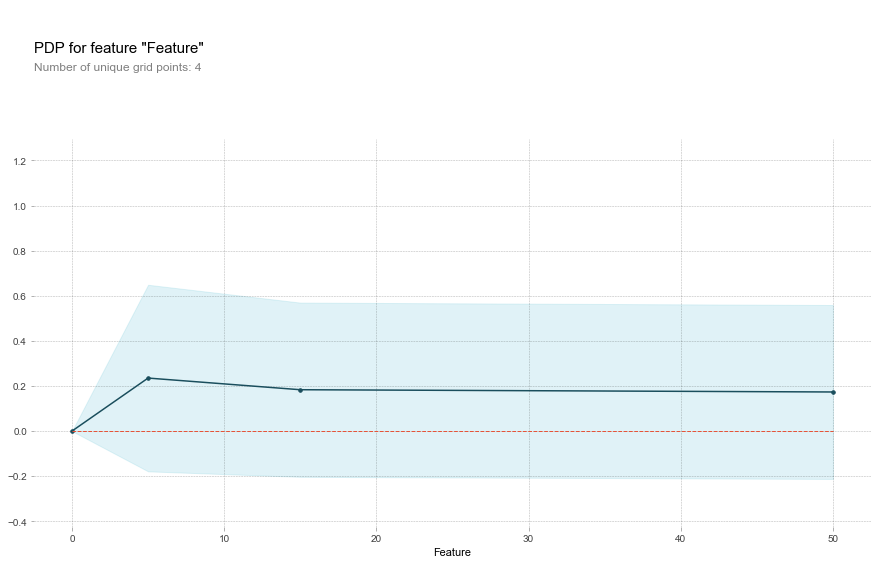

In [231]:
pdp_goals = pdp.pdp_isolate(model=clf_tree_gs_f1, dataset=X_test, model_features=X.columns, feature='Num_Type_VYBER')
pdp.pdp_plot(pdp_goals, 'Feature')
plt.show()

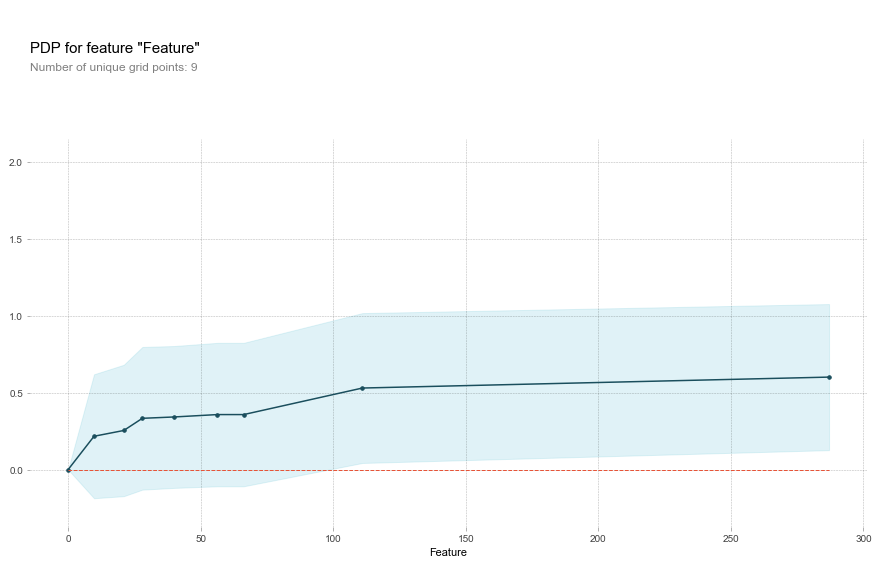

In [233]:
pdp_goals = pdp.pdp_isolate(model=clf_tree_gs_f1, dataset=X_test, model_features=X.columns, feature='Num_Op_Remittances')
pdp.pdp_plot(pdp_goals, 'Feature')
plt.show()

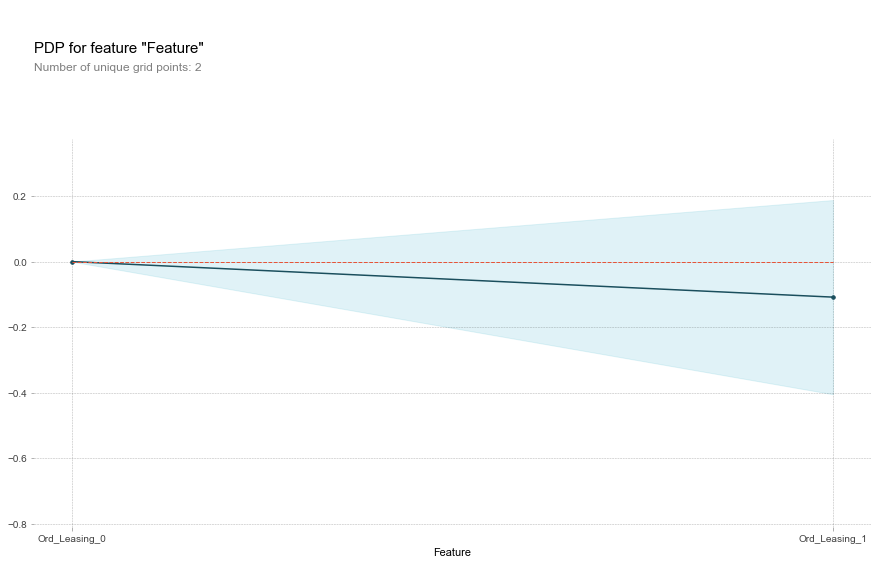

In [232]:
pdp_goals = pdp.pdp_isolate(model=clf_tree_gs_f1, dataset=X_test, model_features=X.columns, feature='Ord_Leasing')
pdp.pdp_plot(pdp_goals, 'Feature')
plt.show()

# Vamos a realizar el análisis ahora con modelos para los que no hay explicabilidad directa. Voy a probar con Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#Vamos a definir la parrilla para realizar Randomized Grid Search

# Máximo número de niveles en el árbol. Damos una distribución con mayor probabilidad en valores pequeños
max_depth1 = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth2 =[int(x) for x in np.linspace(30, 100, num = 4)]
max_depth=max_depth1 + max_depth2
#max_depth.append(None)

# Mínimo número de observaciones en cada hoja.Damos una distribución con mayor probabilidad en valores pequeños
min_samples_leaf_1 = [int(x) for x in np.linspace(5, 50, num = 10)]
min_samples_leaf_2 = [int(x) for x in np.linspace(60, 100, num = 5)]
min_samples_leaf=min_samples_leaf_1+min_samples_leaf_2
#min_samples_leaf.append(None)

# Creamos la grid aleatoria
random_grid = {'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }

clf_tree = DecisionTreeClassifier()
clf_tree_random_p= RandomizedSearchCV(estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="precision")
clf_tree_random_f1= RandomizedSearchCV(estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="f1")

#Comenzamos por el DataFrame X
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf_tree_random_p.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_train,y_train)

eval_modelo_2 (clf_tree_p,X_train,y_train, X_test,y_test)

X.columns[clf_tree_p.feature_importances_>0.10]

#Optimizamos ahora el F1 Score

clf_tree_random_f1.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_train,y_train)

eval_modelo_2 (clf_tree_f1,X_train,y_train, X_test,y_test)

X.columns[clf_tree_f1.feature_importances_>0.10]

#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3)
clf_tree.fit(X_train,y_train)
eval_modelo_2(clf_tree,X_train,y_train, X_test,y_test)

X.columns[clf_tree_f1.feature_importances_>0.10]